<a href="https://colab.research.google.com/github/Nikhil-Nandam/TensorFlow-Notebooks/blob/main/10_Time_Series_Forecasting_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-Series-Forecasting-with-TensorFlow + MileStone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin

⚠️ **Note:** This is not a financial advice!!!

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future prices of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin

In [162]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-332fe0f7-436f-e008-f8ab-0491f36b27f6)


In [163]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-06-25 14:26:44--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-06-25 14:26:45 (11.7 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



## Import TimeSeries with Pandas

In [164]:
# Import with pandas
import pandas as pd

# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])    # parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [165]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [167]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically, deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

Below is a table showcasing what would collecting one sample at different time frames result in:

1 sample per timeframe | Number of samples per year
---------------------- | --------------------------
Second | 31,536,000
Hour | 8,760
Day | 365
Week | 52
Month | 12

> 🔑 **Note:** The **seasonality** of a time series dataset is referred to as the number of samples per year. So, for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.


In [168]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


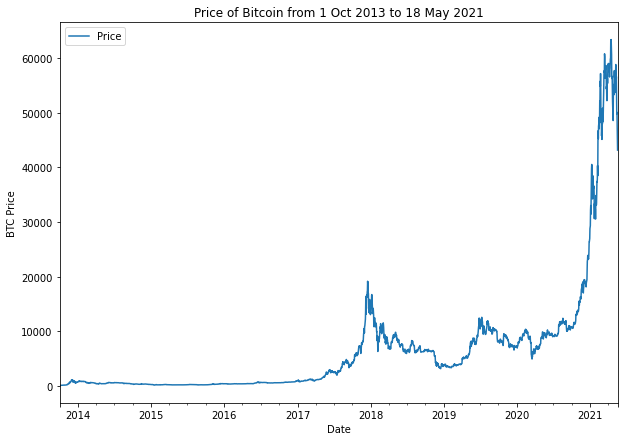

In [169]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.legend();

## Importing time series data with Python's CSV Module

In [170]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader)    # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))    # get the dates as dates (not strings)
        btc_price.append(float(line[2]))    # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

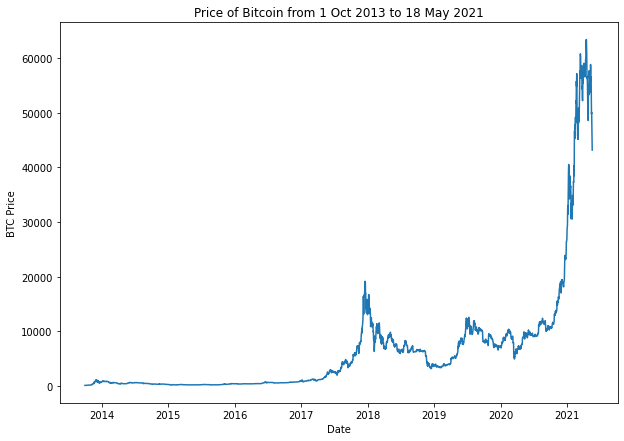

In [171]:
# Plot from CSV
import matplotlib.pyplot as plt
# import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.ylabel("BTC Price")
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [172]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [173]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

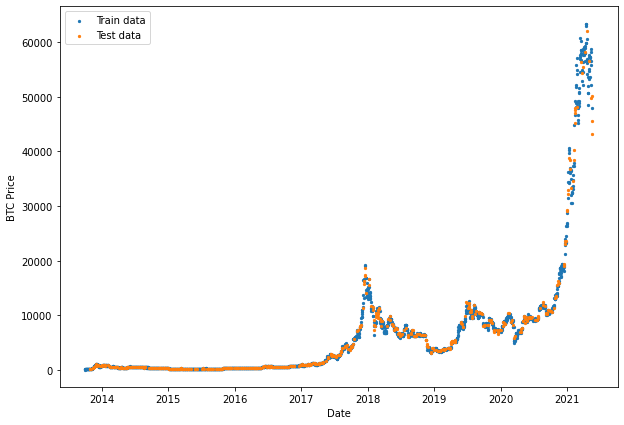

In [174]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend();

### Create train & test sets for time series (the right way)

In [175]:
# Create train and test splits for timeseries data the right way
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

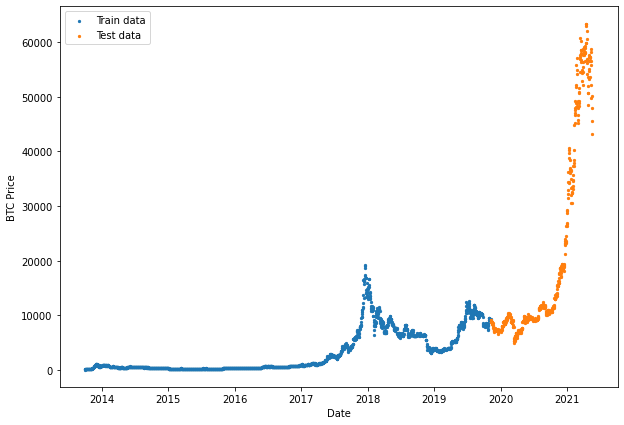

In [176]:
# Let's plot correct train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend();

## Create a plotting function

Typing ploting code is tedious, let's functionize it...

In [177]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps: array of timestep values
    values: array of values across time
    format: style of ploe, default = "."
    start: where to start the plot (setting a value will index from start of timesteps & values)
    end: where to end the plot (similar to start but for the end)
    label: label to show on plot about values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

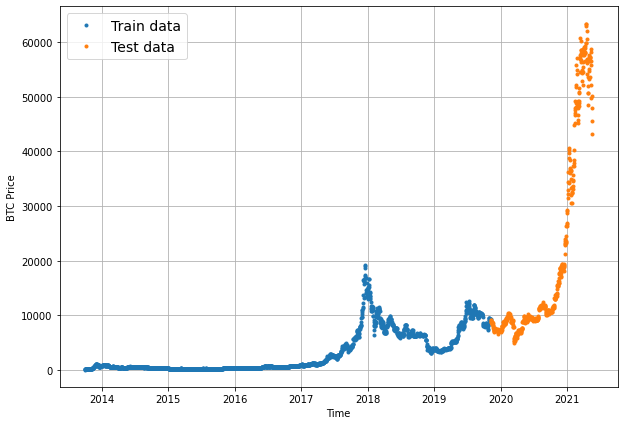

In [178]:
# Test our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon:** Number of timesteps into the future we're going to predict
* **Window size:** Number of timesteps we're going to use to predict *horizon*

Modelling experiments, we're running...

Model Number | Model Type | Horizon size | Window size | Extra data
------------ | ---------- | ------------ | ----------- | ----------
0 | Naïve model (baseline) | NA | NA | NA
1 | Dense model | 1 | 7 | NA
2 | Same architecture as 1 | 1 | 30 | NA
3 | Same architecture as 1 | 7 | 30 | NA
4 | Conv1D | 1 | 7 | NA
5 | LSTM | 1 | 7 | NA
6 | Same as architecture 1 (but with multivariate data) | 1 | 7 | Block reward size
7 | N-BEATs Algorithm | 1 | 7 | NA
8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA
9 | Future prediction model (model to predict future values) | 1 | 7 | NA
10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA

## Model 0: Naïve forecast (Baseline)

The formula looks like:
$$\hat{y}_{t} = y_{t-1}$$

In layman's terms:

> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (previous timestep) - this is for a horizon of 1.

In [179]:
# Create a naïve forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

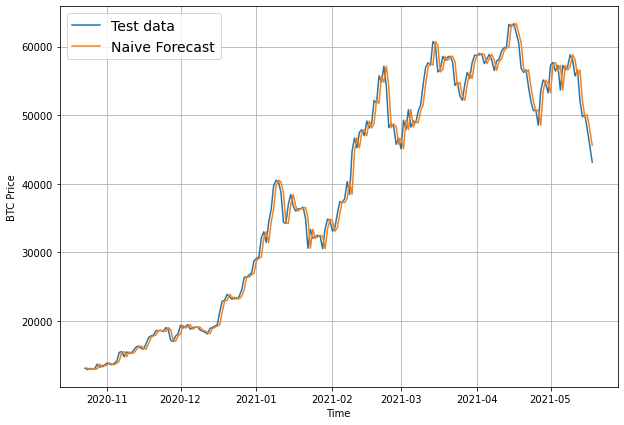

In [180]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, start=350, format="-", label="Test data")
plot_time_series(X_test[1:], naive_forecast, start=350, format="-", label="Naive Forecast")

 >  🛠 **Exercise:** Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. And have a search to find out why the naïve forecast is hard to beat, does the term autoregressive come up?

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a numbers, so that means we have a form of regression problem.

Because we are working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean Absolute Error
* MSE - Mean Squared Error
* RMSE - Root Mean Squared Error
* MAPE/sMAPE - (Symmetric) Mean Absolute Percentage Error
* MASE - Mean Absolute Scaled Error

For all of the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is **how does our model's forecasts (y_pred) compare against the actual values (y_true/ground truth values)**? 

> 📖 **Resource:** For a deeper dive on the various kinds of time series forecasting methods see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

In [181]:
import tensorflow as tf

The formula for MASE is:

$$
q_{j} = \frac{e_{j}} {\frac{1} {T - 1}\sum_{t=2}^{T} \mid {y_{t} - y_{t - 1}}\mid}
$$

$$
MASE = mean(\mid q_{j} \mid) 
$$

In [182]:
# MASE Implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season

In [183]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [184]:
# Create a function to take in model predictions and truth values and return various evaluation metrics
from tensorflow.keras.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

Let's now see if it works...

In [185]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [186]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

In [187]:
# Find minimum and maximum prices of Bitcoin in test dataset
tf.reduce_min(y_test).numpy(), tf.reduce_max(y_test).numpy()

(4944.7023359837, 63346.7890351052)

## Other models you can use for baslines and for actual forecasts

In this notebook, we're focussed on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: 

Model/Library Name | Resource
------------------ | --------
Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime
TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests
Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats
LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our timeseries dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [188]:
btc_price[:8]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033]

In [189]:
# What we want to with our bitcoin data?
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [190]:
# Let's setup global variables for window size and horizon
HORIZON = 1     # predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcoin data to make the prediction

In [191]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset

    E.g. if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [192]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window)} -> Label: {tf.squeeze(test_label)}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our time series.

We could do this with Python for loops, however, for large time series, that would be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#).

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6, 7],
 [2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function we're about to create has been adapted from this [article](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5)

In [193]:
import numpy as np

# Create a function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windoes of window_size with horizon size labels.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T    # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a timeseries) with 2D array of multiple window steps
    windowed_array = x[window_indexes]
    # print(windowed_array)

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [194]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [195]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> Horizon: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Horizon: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Horizon: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Horizon: [125.96116]


In [196]:
# View the last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i - 3]} -> Horizon: {full_labels[i - 3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Horizon: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Horizon: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Horizon: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array), an extension could be to try and replicate what we've done using the premade function.

## Turning windows into training and test sets

In [197]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1 - test_split))   # this will default to 80% train / 20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [198]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [199]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [200]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [201]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON - 1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following:
[`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

In [202]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              monitor="val_loss",
                                              save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previosly we've used 32)
* 100 epochs

----------
* **Hyperparameters:** values a machine learning practitioner can adjust themselves
* **Parameters:** values a model learns on it's own

In [203]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear") # linear acitvation is same as having no activation
], name="model_1_dense")    # name our model so we can save it

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer=Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 788.6984 - mae: 788.6984 - mse: 2353623.0000  INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 35ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 348.8859 - mae: 348.8859 - mse: 600802.6250INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 26ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9993 - val_mae: 1005.9993 - val_mse: 3441833.2500
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 134.4855 - mae: 134.4855 - mse: 70765.6953INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 29ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2862 - val_mae: 923.2861 - val_mse: 2868220.7500
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 211.3724 - mae: 211.3724 - mse: 238018.8906INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 28ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5781 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.5000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 155.7325 - mae: 155.7325 - mse: 88124.5312INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 0s 27ms/step - loss: 165.0894 - mae: 165.0894 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.5000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 117.3681 - mae: 117.3681 - mse: 55147.0820INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 22s 1s/step - loss: 158.5210 - mae: 158.5210 - mse: 133817.7344 - val_loss: 855.1984 - val_mae: 855.1984 - val_mse: 2481873.2500
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 152.2976 - mae: 152.2976 - mse: 125141.5156INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 151.3566 - mae: 151.3566 - mse: 123446.9766 - val_loss: 840.9166 - val_mae: 840.9166 - val_mse: 2276451.5000
Epoch 8/100
15/18 [========================>.....] - ETA: 0s - loss: 143.4757 - mae: 143.4757 - mse: 115762.9922INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 49ms/step - loss: 145.2560 - mae: 145.2560 - mse: 117694.5000 - val_loss: 803.5956 - val_mae: 803.5956 - val_mse: 2140573.5000
Epoch 9/100
15/18 [========================>.....] - ETA: 0s - loss: 145.6129 - mae: 145.6129 - mse: 115800.6328INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 144.3546 - mae: 144.3546 - mse: 115269.3047 - val_loss: 799.5454 - val_mae: 799.5454 - val_mse: 2049207.7500
Epoch 10/100
13/18 [====================>.........] - ETA: 0s - loss: 136.8340 - mae: 136.8340 - mse: 98259.2969 INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 141.2943 - mae: 141.2943 - mse: 112394.5938 - val_loss: 763.5010 - val_mae: 763.5010 - val_mse: 1933140.7500
Epoch 11/100
18/18 [==============================] - 0s 7ms/step - loss: 135.6595 - mae: 135.6595 - mse: 104118.2344 - val_loss: 771.3356 - val_mae: 771.3356 - val_mse: 1885849.7500
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 134.1700 - mae: 134.1700 - mse: 101780.8672 - val_loss: 782.8079 - val_mae: 782.8079 - val_mse: 1881727.1250
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 134.6015 - mae: 134.6015 - mse: 102345.2266 - val_loss: 784.4449 - val_mae: 784.4449 - val_mse: 1860996.1250
Epoch 14/100
14/18 [======================>.......] - ETA: 0s - loss: 130.5572 - mae: 130.5572 - mse: 98402.7578INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 130.6127 - mae: 130.6127 - mse: 96225.1328 - val_loss: 751.3234 - val_mae: 751.3233 - val_mse: 1749609.0000
Epoch 15/100
16/18 [=========================>....] - ETA: 0s - loss: 130.3331 - mae: 130.3331 - mse: 97326.0625INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 128.8347 - mae: 128.8347 - mse: 94306.9922 - val_loss: 696.5756 - val_mae: 696.5756 - val_mse: 1606352.3750
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 124.7739 - mae: 124.7739 - mse: 90394.9375 - val_loss: 702.4698 - val_mae: 702.4698 - val_mse: 1592416.2500
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 123.4474 - mae: 123.4474 - mse: 89247.7031 - val_loss: 704.9239 - val_mae: 704.9239 - val_mse: 1580782.7500
Epoch 18/100
16/18 [=========================>....] - ETA: 0s - loss: 125.6117 - mae: 125.6117 - mse: 92013.4062INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 122.2105 - mae: 122.2105 - mse: 87607.5938 - val_loss: 667.9724 - val_mae: 667.9724 - val_mse: 1498881.8750
Epoch 19/100
18/18 [==============================] - 0s 14ms/step - loss: 121.7263 - mae: 121.7263 - mse: 86632.2422 - val_loss: 718.8796 - val_mae: 718.8796 - val_mse: 1589299.3750
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 121.4032 - mae: 121.4032 - mse: 86429.3594INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 85ms/step - loss: 119.2420 - mae: 119.2420 - mse: 84334.3203 - val_loss: 657.0666 - val_mae: 657.0666 - val_mse: 1447501.1250
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 124.6584 - mae: 124.6584 - mse: 84858.9922INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 55ms/step - loss: 121.2275 - mae: 121.2275 - mse: 85743.3828 - val_loss: 637.0333 - val_mae: 637.0333 - val_mse: 1401774.2500
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 119.9544 - mae: 119.9544 - mse: 84050.1094 - val_loss: 671.2488 - val_mae: 671.2488 - val_mse: 1447895.7500
Epoch 23/100
13/18 [====================>.........] - ETA: 0s - loss: 120.4591 - mae: 120.4591 - mse: 76404.7266INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 121.9248 - mae: 121.9248 - mse: 83746.1250 - val_loss: 633.3592 - val_mae: 633.3592 - val_mse: 1367377.8750
Epoch 24/100
13/18 [====================>.........] - ETA: 0s - loss: 118.6288 - mae: 118.6288 - mse: 89586.0078INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 116.3665 - mae: 116.3665 - mse: 81446.6562 - val_loss: 624.4852 - val_mae: 624.4852 - val_mse: 1348960.6250
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 117.7777 - mae: 117.7777 - mse: 80317.2578INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 114.6816 - mae: 114.6816 - mse: 78912.8359 - val_loss: 619.7570 - val_mae: 619.7570 - val_mse: 1351089.7500
Epoch 26/100
13/18 [====================>.........] - ETA: 0s - loss: 113.1484 - mae: 113.1484 - mse: 67064.0859INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 116.4455 - mae: 116.4455 - mse: 79365.5938 - val_loss: 615.6364 - val_mae: 615.6364 - val_mse: 1321514.3750
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 116.5868 - mae: 116.5868 - mse: 78672.9062 - val_loss: 615.9629 - val_mae: 615.9629 - val_mse: 1313077.5000
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 114.3223 - mae: 114.3223 - mse: 76418.4531INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 113.4691 - mae: 113.4691 - mse: 77440.0938 - val_loss: 608.0921 - val_mae: 608.0921 - val_mse: 1309775.3750
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 113.7598 - mae: 113.7598 - mse: 78506.9531 - val_loss: 621.9305 - val_mae: 621.9305 - val_mse: 1313324.6250
Epoch 30/100
15/18 [========================>.....] - ETA: 0s - loss: 118.0215 - mae: 118.0215 - mse: 80909.7031INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 116.8613 - mae: 116.8613 - mse: 79236.4609 - val_loss: 604.4056 - val_mae: 604.4056 - val_mse: 1283408.0000
Epoch 31/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9375 - mae: 111.9375 - mse: 74849.0703 - val_loss: 609.3882 - val_mae: 609.3882 - val_mse: 1284506.2500
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 112.7391 - mae: 112.7391 - mse: 77842.9766INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 112.4175 - mae: 112.4175 - mse: 77178.5859 - val_loss: 603.0588 - val_mae: 603.0588 - val_mse: 1273059.5000
Epoch 33/100
18/18 [==============================] - 0s 8ms/step - loss: 112.6697 - mae: 112.6697 - mse: 75787.9766 - val_loss: 645.6973 - val_mae: 645.6973 - val_mse: 1353255.7500
Epoch 34/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9867 - mae: 111.9867 - mse: 77245.7266 - val_loss: 604.7634 - val_mae: 604.7634 - val_mse: 1289360.3750
Epoch 35/100
14/18 [======================>.......] - ETA: 0s - loss: 114.2415 - mae: 114.2415 - mse: 80983.5156INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 49ms/step - loss: 110.9451 - mae: 110.9451 - mse: 75301.7812 - val_loss: 593.4648 - val_mae: 593.4648 - val_mse: 1250491.3750
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4816 - mae: 114.4816 - mse: 76138.5391 - val_loss: 608.0074 - val_mae: 608.0074 - val_mse: 1269272.3750
Epoch 37/100
18/18 [==============================] - 0s 8ms/step - loss: 110.2016 - mae: 110.2016 - mse: 74635.3047 - val_loss: 597.2308 - val_mae: 597.2308 - val_mse: 1248474.0000
Epoch 38/100
18/18 [==============================] - 0s 8ms/step - loss: 112.2372 - mae: 112.2372 - mse: 75821.6953 - val_loss: 637.9798 - val_mae: 637.9798 - val_mse: 1366130.8750
Epoch 39/100
14/18 [======================>.......] - ETA: 0s - loss: 117.7033 - mae: 117.7033 - mse: 81882.5547 INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 115.1289 - mae: 115.1289 - mse: 76339.6797 - val_loss: 587.4680 - val_mae: 587.4680 - val_mse: 1233512.3750
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 110.0854 - mae: 110.0854 - mse: 73528.4766 - val_loss: 592.7117 - val_mae: 592.7117 - val_mse: 1251474.6250
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 110.6344 - mae: 110.6344 - mse: 73528.7891 - val_loss: 593.8997 - val_mae: 593.8997 - val_mse: 1253678.5000
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 113.5762 - mae: 113.5762 - mse: 77076.7031 - val_loss: 636.3674 - val_mae: 636.3674 - val_mse: 1317283.5000
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 116.2285 - mae: 116.2285 - mse: 74712.2031 - val_loss: 662.9263 - val_mae: 662.9263 - val_mse: 1419201.7500
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 120.0192 - mae: 120.0192 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 112.4355 - mae: 112.4355 - mse: 73980.3359 - val_loss: 579.7042 - val_mae: 579.7042 - val_mse: 1208301.8750
Epoch 50/100
18/18 [==============================] - 0s 8ms/step - loss: 110.2108 - mae: 110.2108 - mse: 72939.7109 - val_loss: 639.2327 - val_mae: 639.2327 - val_mse: 1347994.1250
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0958 - mae: 111.0958 - mse: 73281.9062 - val_loss: 597.3571 - val_mae: 597.3571 - val_mse: 1229791.1250
Epoch 52/100
18/18 [==============================] - 0s 8ms/step - loss: 110.7351 - mae: 110.7351 - mse: 74529.6328 - val_loss: 580.7227 - val_mae: 580.7227 - val_mse: 1215477.1250
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 111.1785 - mae: 111.1785 - mse: 74149.4766 - val_loss: 648.3586 - val_mae: 648.3586 - val_mse: 1336951.1250
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 114.0831 - mae: 114.0831 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 110.4910 - mae: 110.4910 - mse: 74711.2500 - val_loss: 579.5067 - val_mae: 579.5067 - val_mse: 1211580.3750
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 108.0488 - mae: 108.0488 - mse: 71844.1562 - val_loss: 807.3853 - val_mae: 807.3853 - val_mse: 1859292.5000
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 125.0614 - mae: 125.0614 - mse: 84025.2812 - val_loss: 674.1658 - val_mae: 674.1658 - val_mse: 1437686.8750
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 115.4340 - mae: 115.4340 - mse: 73710.7422 - val_loss: 582.2697 - val_mae: 582.2697 - val_mse: 1202679.3750
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 110.0881 - mae: 110.0881 - mse: 72845.1172 - val_loss: 606.7640 - val_mae: 606.7640 - val_mse: 1267544.0000
Epoch 60/100
18/18 [==============================] - 0s 9ms/step - loss: 108.7156 - mae: 108.7156 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 108.1525 - mae: 108.1525 - mse: 72252.1250 - val_loss: 573.9990 - val_mae: 573.9990 - val_mse: 1189583.5000
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 107.3726 - mae: 107.3726 - mse: 70822.7891 - val_loss: 581.7015 - val_mae: 581.7015 - val_mse: 1214006.6250
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 110.7667 - mae: 110.7667 - mse: 73178.4453 - val_loss: 637.5243 - val_mae: 637.5243 - val_mse: 1311201.6250
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 110.1539 - mae: 110.1539 - mse: 72588.2188 - val_loss: 586.6598 - val_mae: 586.6598 - val_mse: 1207116.3750
Epoch 65/100
10/18 [===============>..............] - ETA: 0s - loss: 107.9271 - mae: 107.9271 - mse: 73952.3516 INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 108.2325 - mae: 108.2325 - mse: 71962.0859 - val_loss: 573.5618 - val_mae: 573.5618 - val_mse: 1188986.2500
Epoch 66/100
17/18 [===========================>..] - ETA: 0s - loss: 108.8999 - mae: 108.8999 - mse: 71784.4062INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 45ms/step - loss: 108.6825 - mae: 108.6825 - mse: 71026.3516 - val_loss: 572.2206 - val_mae: 572.2206 - val_mse: 1187818.3750
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 106.6371 - mae: 106.6371 - mse: 70166.2578 - val_loss: 646.6359 - val_mae: 646.6359 - val_mse: 1356393.0000
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 114.1603 - mae: 114.1603 - mse: 71297.3203 - val_loss: 681.8572 - val_mae: 681.8572 - val_mse: 1455430.5000
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 124.5514 - mae: 124.5514 - mse: 81238.9609 - val_loss: 655.9892 - val_mae: 655.9892 - val_mse: 1383324.6250
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 125.0234 - mae: 125.0234 - mse: 83058.2109 - val_loss: 601.0039 - val_mae: 601.0039 - val_mse: 1256963.6250
Epoch 71/100
18/18 [==============================] - 0s 8ms/step - loss: 110.3652 - mae: 110.3652 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 107.5879 - mae: 107.5879 - mse: 70333.8359 - val_loss: 571.9301 - val_mae: 571.9301 - val_mse: 1186830.0000
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 108.1598 - mae: 108.1598 - mse: 70200.0781 - val_loss: 575.2387 - val_mae: 575.2387 - val_mse: 1195318.0000
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 107.9175 - mae: 107.9175 - mse: 72451.5859 - val_loss: 617.3083 - val_mae: 617.3083 - val_mse: 1285512.3750
Epoch 80/100
18/18 [==============================] - 0s 8ms/step - loss: 108.9510 - mae: 108.9510 - mse: 72158.7812 - val_loss: 583.4841 - val_mae: 583.4841 - val_mse: 1194356.7500
Epoch 81/100
13/18 [====================>.........] - ETA: 0s - loss: 102.9374 - mae: 102.9374 - mse: 67870.4062INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 106.0505 - mae: 106.0505 - mse: 69690.9219 - val_loss: 570.0803 - val_mae: 570.0803 - val_mse: 1177237.8750
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6827 - mae: 115.6827 - mse: 76903.4922 - val_loss: 575.7388 - val_mae: 575.7388 - val_mse: 1194662.6250
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 110.9379 - mae: 110.9379 - mse: 72968.3047 - val_loss: 659.6579 - val_mae: 659.6579 - val_mse: 1388829.8750
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4836 - mae: 111.4836 - mse: 73017.9453 - val_loss: 570.1957 - val_mae: 570.1957 - val_mse: 1177492.2500
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 107.5949 - mae: 107.5949 - mse: 70728.2266 - val_loss: 601.5939 - val_mae: 601.5939 - val_mse: 1228450.7500
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 108.9425 - mae: 108.9425 - m

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 107.9217 - mae: 107.9217 - mse: 71668.0469 - val_loss: 569.0500 - val_mae: 569.0500 - val_mse: 1174588.3750
Epoch 89/100
15/18 [========================>.....] - ETA: 0s - loss: 99.8452 - mae: 99.8452 - mse: 62531.2422  INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 106.0344 - mae: 106.0344 - mse: 68979.1484 - val_loss: 568.9510 - val_mae: 568.9510 - val_mse: 1171743.5000
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 105.4977 - mae: 105.4977 - mse: 67516.5000 - val_loss: 581.7677 - val_mae: 581.7677 - val_mse: 1190160.5000
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 108.8468 - mae: 108.8468 - mse: 71112.3281 - val_loss: 573.6025 - val_mae: 573.6025 - val_mse: 1185216.0000
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 110.8884 - mae: 110.8884 - mse: 73287.8125 - val_loss: 576.8243 - val_mae: 576.8243 - val_mse: 1181628.3750
Epoch 93/100
18/18 [==============================] - 0s 8ms/step - loss: 113.8781 - mae: 113.8781 - mse: 75236.4375 - val_loss: 608.3022 - val_mae: 608.3022 - val_mse: 1264206.1250
Epoch 94/100
18/18 [==============================] - 0s 9ms/step - loss: 110.5763 - mae: 110.5763 - m

In [204]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [205]:
# Load in the saved best performing model_1 and evaluate it on test data
from tensorflow.keras.models import load_model

model_1 = load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Takes in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [206]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [207]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [208]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [209]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171743.8,
 'rmse': 1082.4711}

In [210]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

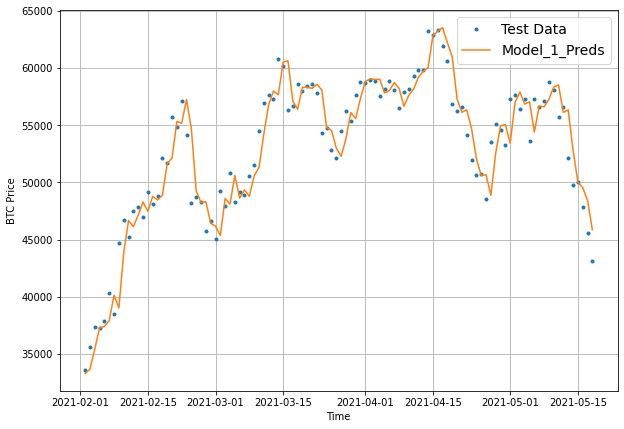

In [211]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 start=offset,
                 format="-", 
                 label="Model_1_Preds")

## Model 2: Dense (window = 30, horizon = 1)

In [212]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30    # use 30 timesteps in past

In [213]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [214]:
# Make train an testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [215]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [216]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_2 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear") # linear acitvation is same as having no activation
], name="model_2_dense")    # name our model so we can save it

# 2. Compile the model
model_2.compile(loss="mae",
                optimizer=Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
history_model_2 = model_2.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 1122.7756 - mae: 1122.7756 - mse: 4929193.0000  INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 2s 98ms/step - loss: 1097.0399 - mae: 1097.0399 - mse: 4741506.0000 - val_loss: 3900.2537 - val_mae: 3900.2537 - val_mse: 32752730.0000
Epoch 2/100
14/18 [======================>.......] - ETA: 0s - loss: 449.0891 - mae: 449.0891 - mse: 873495.6250 INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 428.0732 - mae: 428.0732 - mse: 811548.2500 - val_loss: 1587.0745 - val_mae: 1587.0745 - val_mse: 6817661.5000
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 293.6918 - mae: 293.6918 - mse: 403872.2188INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 51ms/step - loss: 279.7655 - mae: 279.7655 - mse: 363083.0625 - val_loss: 1220.6888 - val_mae: 1220.6888 - val_mse: 4447002.0000
Epoch 4/100
 9/18 [==============>...............] - ETA: 0s - loss: 215.5194 - mae: 215.5194 - mse: 214022.9375INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 224.3637 - mae: 224.3637 - mse: 225072.2188 - val_loss: 1160.1572 - val_mae: 1160.1572 - val_mse: 3837504.2500
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 185.3824 - mae: 185.3824 - mse: 170974.9844INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 187.9681 - mae: 187.9681 - mse: 173777.0312 - val_loss: 1007.6487 - val_mae: 1007.6487 - val_mse: 3224229.0000
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 182.9174 - mae: 182.9174 - mse: 162950.3750 - val_loss: 1019.5818 - val_mae: 1019.5818 - val_mse: 3408885.2500
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 187.7612 - mae: 187.7612 - mse: 159475.8750 - val_loss: 1145.1758 - val_mae: 1145.1758 - val_mse: 4078532.2500
Epoch 8/100
13/18 [====================>.........] - ETA: 0s - loss: 190.9780 - mae: 190.9780 - mse: 180003.2188INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 192.2202 - mae: 192.2202 - mse: 172722.5469 - val_loss: 967.8077 - val_mae: 967.8077 - val_mse: 2845453.7500
Epoch 9/100
14/18 [======================>.......] - ETA: 0s - loss: 172.0857 - mae: 172.0857 - mse: 149833.5781INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 167.4042 - mae: 167.4042 - mse: 141257.4688 - val_loss: 896.5217 - val_mae: 896.5217 - val_mse: 2643020.0000
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 163.8977 - mae: 163.8977 - mse: 133476.6250INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 161.6689 - mae: 161.6689 - mse: 132314.9688 - val_loss: 881.9178 - val_mae: 881.9178 - val_mse: 2558588.0000
Epoch 11/100
13/18 [====================>.........] - ETA: 0s - loss: 159.6389 - mae: 159.6389 - mse: 126517.9531INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 162.2630 - mae: 162.2630 - mse: 127474.1406 - val_loss: 862.7010 - val_mae: 862.7010 - val_mse: 2432215.0000
Epoch 12/100
17/18 [===========================>..] - ETA: 0s - loss: 157.8958 - mae: 157.8958 - mse: 127251.0859INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 49ms/step - loss: 157.6156 - mae: 157.6156 - mse: 126629.2812 - val_loss: 855.2238 - val_mae: 855.2238 - val_mse: 2351040.0000
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 160.0478 - mae: 160.0478 - mse: 122629.6797INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 164.3571 - mae: 164.3571 - mse: 130452.2422 - val_loss: 845.0386 - val_mae: 845.0386 - val_mse: 2380580.0000
Epoch 14/100
12/18 [===================>..........] - ETA: 0s - loss: 157.9376 - mae: 157.9376 - mse: 130435.6797INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 152.4233 - mae: 152.4233 - mse: 119918.8594 - val_loss: 835.7405 - val_mae: 835.7405 - val_mse: 2279386.5000
Epoch 15/100
18/18 [==============================] - 0s 7ms/step - loss: 165.0978 - mae: 165.0978 - mse: 126962.9844 - val_loss: 920.6229 - val_mae: 920.6229 - val_mse: 2756908.7500
Epoch 16/100
13/18 [====================>.........] - ETA: 0s - loss: 173.2645 - mae: 173.2645 - mse: 132405.2656INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 166.0639 - mae: 166.0639 - mse: 126534.0625 - val_loss: 814.6472 - val_mae: 814.6472 - val_mse: 2187638.0000
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 165.1733 - mae: 165.1733 - mse: 130918.6875 - val_loss: 939.7372 - val_mae: 939.7372 - val_mse: 2560630.7500
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 158.3085 - mae: 158.3085 - mse: 122879.3594 - val_loss: 929.8369 - val_mae: 929.8369 - val_mse: 2522551.7500
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 151.6603 - mae: 151.6603 - mse: 113185.5625 - val_loss: 1071.7583 - val_mae: 1071.7583 - val_mse: 3444894.7500
Epoch 20/100
18/18 [==============================] - 0s 7ms/step - loss: 155.9877 - mae: 155.9877 - mse: 123244.1797 - val_loss: 906.9962 - val_mae: 906.9962 - val_mse: 2416914.0000
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 150.9352 - mae: 150.9

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 161.7742 - mae: 161.7742 - mse: 121110.6250 - val_loss: 794.9154 - val_mae: 794.9154 - val_mse: 2019348.3750
Epoch 25/100
18/18 [==============================] - 0s 7ms/step - loss: 147.8488 - mae: 147.8488 - mse: 110879.7656 - val_loss: 1092.2104 - val_mae: 1092.2104 - val_mse: 3088394.7500
Epoch 26/100
18/18 [==============================] - 0s 7ms/step - loss: 150.0337 - mae: 150.0337 - mse: 111213.2812 - val_loss: 802.3950 - val_mae: 802.3950 - val_mse: 2125820.2500
Epoch 27/100
14/18 [======================>.......] - ETA: 0s - loss: 161.8363 - mae: 161.8363 - mse: 119062.8828INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 154.9933 - mae: 154.9933 - mse: 109837.4766 - val_loss: 748.0327 - val_mae: 748.0327 - val_mse: 1870825.3750
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 141.5399 - mae: 141.5399 - mse: 101088.8594 - val_loss: 960.1356 - val_mae: 960.1356 - val_mse: 2812905.7500
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 148.5069 - mae: 148.5069 - mse: 110140.6641 - val_loss: 758.3329 - val_mae: 758.3329 - val_mse: 1871426.0000
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 148.1240 - mae: 148.1240 - mse: 108366.9297 - val_loss: 988.7416 - val_mae: 988.7416 - val_mse: 2639810.2500
Epoch 31/100
18/18 [==============================] - 0s 9ms/step - loss: 142.3972 - mae: 142.3972 - mse: 100558.5703 - val_loss: 847.3676 - val_mae: 847.3676 - val_mse: 2286142.5000
Epoch 32/100
13/18 [====================>.........] - ETA: 0s - loss: 152.4248 - mae: 152.4248 - 

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 148.1294 - mae: 148.1294 - mse: 106817.7812 - val_loss: 726.4918 - val_mae: 726.4918 - val_mse: 1772761.8750
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 141.7309 - mae: 141.7309 - mse: 102930.2734 - val_loss: 767.2233 - val_mae: 767.2233 - val_mse: 1945827.2500
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 132.8567 - mae: 132.8567 - mse: 87645.8906INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 135.4458 - mae: 135.4458 - mse: 92370.8281 - val_loss: 721.9368 - val_mae: 721.9368 - val_mse: 1763867.0000
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 131.7838 - mae: 131.7838 - mse: 91448.7891 - val_loss: 759.3353 - val_mae: 759.3353 - val_mse: 1836807.0000
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 131.5018 - mae: 131.5018 - mse: 92934.0938 - val_loss: 814.7689 - val_mae: 814.7689 - val_mse: 1997793.3750
Epoch 37/100
14/18 [======================>.......] - ETA: 0s - loss: 146.5008 - mae: 146.5008 - mse: 104689.6484INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 143.4647 - mae: 143.4647 - mse: 100143.1094 - val_loss: 708.7821 - val_mae: 708.7821 - val_mse: 1696078.6250
Epoch 38/100
18/18 [==============================] - 0s 7ms/step - loss: 134.5705 - mae: 134.5705 - mse: 92221.2344 - val_loss: 821.9357 - val_mae: 821.9357 - val_mse: 2149077.7500
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 137.7672 - mae: 137.7672 - mse: 98614.1953 - val_loss: 969.4777 - val_mae: 969.4777 - val_mse: 2517117.5000
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 142.7820 - mae: 142.7820 - mse: 91609.3047 - val_loss: 901.4053 - val_mae: 901.4053 - val_mse: 2259121.5000
Epoch 41/100
14/18 [======================>.......] - ETA: 0s - loss: 142.9348 - mae: 142.9348 - mse: 99961.7969INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 51ms/step - loss: 142.1888 - mae: 142.1888 - mse: 98998.3359 - val_loss: 689.8060 - val_mae: 689.8060 - val_mse: 1620425.2500
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 130.9877 - mae: 130.9877 - mse: 88242.9141 - val_loss: 751.3142 - val_mae: 751.3142 - val_mse: 1782372.8750
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 131.4450 - mae: 131.4450 - mse: 90820.2266 - val_loss: 746.7275 - val_mae: 746.7275 - val_mse: 1830367.7500
Epoch 44/100
18/18 [==============================] - 0s 7ms/step - loss: 137.5511 - mae: 137.5511 - mse: 96568.3281 - val_loss: 751.4652 - val_mae: 751.4652 - val_mse: 1842565.7500
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 134.3822 - mae: 134.3822 - mse: 93087.4297 - val_loss: 694.2699 - val_mae: 694.2699 - val_mse: 1617442.1250
Epoch 46/100
10/18 [===============>..............] - ETA: 0s - loss: 125.0311 - mae: 125.0311 - mse: 

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 80ms/step - loss: 127.4527 - mae: 127.4527 - mse: 87612.0781 - val_loss: 676.5610 - val_mae: 676.5610 - val_mse: 1555773.0000
Epoch 47/100
18/18 [==============================] - 0s 12ms/step - loss: 136.6635 - mae: 136.6635 - mse: 92716.2344 - val_loss: 1113.9982 - val_mae: 1113.9982 - val_mse: 3065015.7500
Epoch 48/100
 9/18 [==============>...............] - ETA: 0s - loss: 168.1710 - mae: 168.1710 - mse: 122081.8594INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 164.2887 - mae: 164.2887 - mse: 117708.3984 - val_loss: 667.6456 - val_mae: 667.6456 - val_mse: 1524165.5000
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 127.9774 - mae: 127.9774 - mse: 85549.1797 - val_loss: 718.8885 - val_mae: 718.8885 - val_mse: 1691650.7500
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 141.8780 - mae: 141.8780 - mse: 93444.8984 - val_loss: 829.6292 - val_mae: 829.6292 - val_mse: 2098737.5000
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 129.4569 - mae: 129.4569 - mse: 87931.0703 - val_loss: 987.5338 - val_mae: 987.5338 - val_mse: 2758906.0000
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 141.4287 - mae: 141.4287 - mse: 98486.4609 - val_loss: 715.3037 - val_mae: 715.3037 - val_mse: 1633319.6250
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 146.1227 - mae: 146.1227 - 

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 162.9252 - mae: 162.9252 - mse: 116505.1250 - val_loss: 658.4476 - val_mae: 658.4476 - val_mse: 1469404.1250
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 134.5520 - mae: 134.5520 - mse: 88455.0234 - val_loss: 906.1519 - val_mae: 906.1519 - val_mse: 2212985.0000
Epoch 56/100
18/18 [==============================] - 0s 8ms/step - loss: 132.1189 - mae: 132.1189 - mse: 88770.3125 - val_loss: 658.8979 - val_mae: 658.8979 - val_mse: 1476355.6250
Epoch 57/100
14/18 [======================>.......] - ETA: 0s - loss: 122.7331 - mae: 122.7331 - mse: 82480.9922INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 45ms/step - loss: 128.6264 - mae: 128.6264 - mse: 84349.8281 - val_loss: 648.7651 - val_mae: 648.7651 - val_mse: 1439428.0000
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 133.0039 - mae: 133.0039 - mse: 89231.0938 - val_loss: 760.6868 - val_mae: 760.6868 - val_mse: 1814641.8750
Epoch 59/100
18/18 [==============================] - 0s 8ms/step - loss: 167.5204 - mae: 167.5204 - mse: 119260.3438 - val_loss: 699.1824 - val_mae: 699.1824 - val_mse: 1592398.1250
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 121.4026 - mae: 121.4026 - mse: 78786.4297 - val_loss: 784.7621 - val_mae: 784.7621 - val_mse: 1797242.2500
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 131.8212 - mae: 131.8212 - mse: 87380.6250 - val_loss: 761.1855 - val_mae: 761.1855 - val_mse: 1800775.5000
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 133.7610 - mae: 133.7610 - 

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 129.3582 - mae: 129.3582 - mse: 84437.2812 - val_loss: 638.4762 - val_mae: 638.4762 - val_mse: 1393845.1250
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 121.8753 - mae: 121.8753 - mse: 81456.2109 - val_loss: 735.8253 - val_mae: 735.8253 - val_mse: 1694805.5000
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 124.5709 - mae: 124.5709 - mse: 82757.4375 - val_loss: 702.7538 - val_mae: 702.7538 - val_mse: 1596079.2500
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 134.1436 - mae: 134.1436 - mse: 89529.9453 - val_loss: 640.6722 - val_mae: 640.6722 - val_mse: 1398268.8750
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 123.1770 - mae: 123.1770 - mse: 80330.8672 - val_loss: 1110.4432 - val_mae: 1110.4432 - val_mse: 2994969.0000
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 135.9602 - mae: 135.9602 -

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 128.7049 - mae: 128.7049 - mse: 86091.0781 - val_loss: 636.7365 - val_mae: 636.7365 - val_mse: 1380941.6250
Epoch 72/100
14/18 [======================>.......] - ETA: 0s - loss: 124.9074 - mae: 124.9074 - mse: 85851.2500INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 43ms/step - loss: 120.7498 - mae: 120.7498 - mse: 80539.0547 - val_loss: 636.1567 - val_mae: 636.1567 - val_mse: 1384186.6250
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 119.8846 - mae: 119.8846 - mse: 78536.1172 - val_loss: 722.2628 - val_mae: 722.2628 - val_mse: 1590577.5000
Epoch 74/100
15/18 [========================>.....] - ETA: 0s - loss: 125.1415 - mae: 125.1415 - mse: 85193.5938INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 83ms/step - loss: 128.0455 - mae: 128.0455 - mse: 83733.4062 - val_loss: 622.5280 - val_mae: 622.5280 - val_mse: 1334697.0000
Epoch 75/100
14/18 [======================>.......] - ETA: 0s - loss: 126.7104 - mae: 126.7104 - mse: 86398.9922INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 51ms/step - loss: 122.0446 - mae: 122.0446 - mse: 79881.0156 - val_loss: 619.5175 - val_mae: 619.5175 - val_mse: 1324510.2500
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 122.6730 - mae: 122.6730 - mse: 80796.2812 - val_loss: 856.6989 - val_mae: 856.6988 - val_mse: 2004174.6250
Epoch 77/100
18/18 [==============================] - 0s 8ms/step - loss: 126.3470 - mae: 126.3470 - mse: 80182.0469 - val_loss: 641.5902 - val_mae: 641.5902 - val_mse: 1378807.6250
Epoch 78/100
18/18 [==============================] - 0s 10ms/step - loss: 118.5847 - mae: 118.5847 - mse: 78303.8281 - val_loss: 690.7908 - val_mae: 690.7908 - val_mse: 1531805.1250
Epoch 79/100
18/18 [==============================] - 0s 8ms/step - loss: 131.4505 - mae: 131.4505 - mse: 85134.6875 - val_loss: 621.2333 - val_mae: 621.2333 - val_mse: 1327195.3750
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 125.0166 - mae: 125.0166 - 

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 139.8416 - mae: 139.8416 - mse: 90350.6797 - val_loss: 616.3276 - val_mae: 616.3276 - val_mse: 1309630.0000
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 134.8590 - mae: 134.8590 - mse: 85241.6250 - val_loss: 1100.9899 - val_mae: 1100.9899 - val_mse: 2912869.5000
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 152.7612 - mae: 152.7612 - mse: 104070.4531 - val_loss: 815.0580 - val_mae: 815.0580 - val_mse: 1857857.1250
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 160.4490 - mae: 160.4490 - mse: 107181.4141 - val_loss: 1111.4733 - val_mae: 1111.4733 - val_mse: 2971819.5000
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 134.0435 - mae: 134.0435 - mse: 86288.1016 - val_loss: 810.8096 - val_mae: 810.8096 - val_mse: 1923505.3750
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 127.9937 - mae: 127.99

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets


18/18 [==============================] - 1s 50ms/step - loss: 133.0909 - mae: 133.0909 - mse: 91028.2344 - val_loss: 605.8741 - val_mae: 605.8741 - val_mse: 1273361.1250
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 117.5806 - mae: 117.5806 - mse: 75189.4219 - val_loss: 706.8725 - val_mae: 706.8725 - val_mse: 1551657.5000
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 120.7865 - mae: 120.7865 - mse: 76582.7031 - val_loss: 718.7263 - val_mae: 718.7263 - val_mse: 1555904.8750
Epoch 99/100
18/18 [==============================] - 0s 6ms/step - loss: 125.8117 - mae: 125.8117 - mse: 78376.3047 - val_loss: 988.9795 - val_mae: 988.9795 - val_mse: 2610509.5000
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 124.1724 - mae: 124.1724 - mse: 83770.4688 - val_loss: 659.3332 - val_mae: 659.3332 - val_mse: 1397247.5000


In [217]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 659.3332 - mae: 659.3332 - mse: 1397247.7500


[659.3331909179688, 659.3331909179688, 1397247.75]

In [218]:
# Load in the best performing model
model_2 = load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 605.8741 - mae: 605.8741 - mse: 1273360.7500


[605.8740844726562, 605.8740844726562, 1273360.75]

In [219]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [220]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mape': 2.726445,
 'mase': 1.0590738,
 'mse': 1273360.8,
 'rmse': 1128.4329}

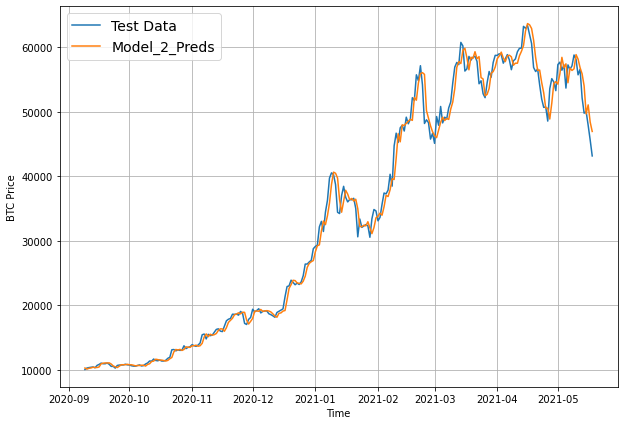

In [221]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model_2_Preds")

## Model 3: Dense (window = 30, horizon = 7)

In [222]:
HORIZON = 7 # predict one step at a time (one week of Bitcoin prices)
WINDOW_SIZE = 30    # use 30 timesteps in past

In [223]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [224]:
# Make train an testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [225]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [226]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_3 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear") # linear acitvation is same as having no activation
], name="model_3_dense")    # name our model so we can save it

# 2. Compile the model
model_3.compile(loss="mae",
                optimizer=Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
history_model_3 = model_3.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 1729.9012 - mae: 1729.9012 - mse: 13155354.0000 INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 2s 58ms/step - loss: 1476.6752 - mae: 1476.6752 - mse: 10390733.0000 - val_loss: 3088.5613 - val_mae: 3088.5613 - val_mse: 24386346.0000
Epoch 2/100
 9/18 [==============>...............] - ETA: 0s - loss: 577.7521 - mae: 577.7521 - mse: 1385237.2500INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 51ms/step - loss: 552.8943 - mae: 552.8943 - mse: 1336176.8750 - val_loss: 2462.4548 - val_mae: 2462.4548 - val_mse: 17112268.0000
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 445.2850 - mae: 445.2850 - mse: 899533.3125INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 435.1978 - mae: 435.1978 - mse: 893449.0000 - val_loss: 2283.1484 - val_mae: 2283.1484 - val_mse: 14950889.0000
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 393.5517 - mae: 393.5517 - mse: 760006.7500 INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 391.9787 - mae: 391.9787 - mse: 745983.8125 - val_loss: 1975.1218 - val_mae: 1975.1218 - val_mse: 11680637.0000
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 357.9485 - mae: 357.9485 - mse: 627137.9375 - val_loss: 2000.1556 - val_mae: 2000.1556 - val_mse: 11665231.0000
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 333.4438 - mae: 333.4438 - mse: 533769.2500INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 45ms/step - loss: 332.6704 - mae: 332.6704 - mse: 531746.6250 - val_loss: 1723.4186 - val_mae: 1723.4186 - val_mse: 9019992.0000
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 309.9903 - mae: 309.9903 - mse: 470480.5312INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 45ms/step - loss: 309.9903 - mae: 309.9903 - mse: 470480.5312 - val_loss: 1591.9688 - val_mae: 1591.9688 - val_mse: 7895366.0000
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 305.3100 - mae: 305.3100 - mse: 444828.7812INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 302.4123 - mae: 302.4123 - mse: 438359.1250 - val_loss: 1579.8518 - val_mae: 1579.8518 - val_mse: 7899042.0000
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 293.9170 - mae: 293.9170 - mse: 418137.7188 - val_loss: 1602.9116 - val_mae: 1602.9116 - val_mse: 7739274.0000
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 291.8953 - mae: 291.8953 - mse: 388581.7500INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 44ms/step - loss: 291.5431 - mae: 291.5431 - mse: 402053.9688 - val_loss: 1504.9114 - val_mae: 1504.9114 - val_mse: 7034896.5000
Epoch 11/100
13/18 [====================>.........] - ETA: 0s - loss: 280.9339 - mae: 280.9339 - mse: 381877.0000INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 282.3861 - mae: 282.3861 - mse: 387283.0625 - val_loss: 1474.9521 - val_mae: 1474.9521 - val_mse: 6938312.5000
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 276.0491 - mae: 276.0491 - mse: 374895.8125 - val_loss: 1539.4847 - val_mae: 1539.4847 - val_mse: 7364822.5000
Epoch 13/100
12/18 [===================>..........] - ETA: 0s - loss: 263.4532 - mae: 263.4532 - mse: 349456.2188INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 272.3232 - mae: 272.3232 - mse: 365701.9375 - val_loss: 1459.5269 - val_mae: 1459.5269 - val_mse: 6738909.0000
Epoch 14/100
14/18 [======================>.......] - ETA: 0s - loss: 257.7140 - mae: 257.7140 - mse: 338922.3438INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 45ms/step - loss: 270.6817 - mae: 270.6817 - mse: 367210.9688 - val_loss: 1417.0792 - val_mae: 1417.0792 - val_mse: 6493178.5000
Epoch 15/100
18/18 [==============================] - 0s 7ms/step - loss: 263.8875 - mae: 263.8875 - mse: 351648.9062 - val_loss: 1541.0621 - val_mae: 1541.0621 - val_mse: 7139703.0000
Epoch 16/100
18/18 [==============================] - 0s 7ms/step - loss: 265.9065 - mae: 265.9065 - mse: 352247.7188 - val_loss: 1441.2795 - val_mae: 1441.2795 - val_mse: 6551795.5000
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 262.9132 - mae: 262.9132 - mse: 348013.6875 - val_loss: 1505.8213 - val_mae: 1505.8213 - val_mse: 7021491.0000
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 260.1363 - mae: 260.1363 - mse: 338809.7500 - val_loss: 1446.3213 - val_mae: 1446.3213 - val_mse: 6640532.0000
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 258.2223 - ma

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 258.0463 - mae: 258.0463 - mse: 330457.5625 - val_loss: 1384.9282 - val_mae: 1384.9282 - val_mse: 6376790.5000
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 272.9519 - mae: 272.9519 - mse: 356811.5000INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 49ms/step - loss: 269.2109 - mae: 269.2109 - mse: 348474.7188 - val_loss: 1377.6122 - val_mae: 1377.6122 - val_mse: 6264392.5000
Epoch 25/100
18/18 [==============================] - 0s 7ms/step - loss: 253.5239 - mae: 253.5239 - mse: 322304.0625 - val_loss: 1452.3351 - val_mae: 1452.3351 - val_mse: 6649548.5000
Epoch 26/100
18/18 [==============================] - 0s 8ms/step - loss: 252.1648 - mae: 252.1648 - mse: 319006.6250 - val_loss: 1388.5122 - val_mae: 1388.5122 - val_mse: 6325646.5000
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 251.8276 - mae: 251.8276 - mse: 322080.4375 - val_loss: 1451.5784 - val_mae: 1451.5784 - val_mse: 6515207.5000
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 247.8791 - mae: 247.8791 - mse: 313790.8750 - val_loss: 1391.4445 - val_mae: 1391.4445 - val_mse: 6381010.5000
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 246.0225 - ma

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 248.2236 - mae: 248.2236 - mse: 317049.2812 - val_loss: 1336.2773 - val_mae: 1336.2773 - val_mse: 6054735.5000
Epoch 31/100
14/18 [======================>.......] - ETA: 0s - loss: 233.1581 - mae: 233.1581 - mse: 277890.8125INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 242.1411 - mae: 242.1411 - mse: 303474.5312 - val_loss: 1334.8569 - val_mae: 1334.8569 - val_mse: 6053588.0000
Epoch 32/100
14/18 [======================>.......] - ETA: 0s - loss: 242.8755 - mae: 242.8755 - mse: 305975.9688INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 245.8559 - mae: 245.8559 - mse: 309413.2188 - val_loss: 1329.1195 - val_mae: 1329.1195 - val_mse: 5981315.0000
Epoch 33/100
18/18 [==============================] - 0s 8ms/step - loss: 246.9277 - mae: 246.9277 - mse: 310413.8438 - val_loss: 1372.8105 - val_mae: 1372.8105 - val_mse: 6171215.0000
Epoch 34/100
18/18 [==============================] - 0s 8ms/step - loss: 244.2540 - mae: 244.2540 - mse: 305681.9375 - val_loss: 1373.9778 - val_mae: 1373.9778 - val_mse: 6200631.5000
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 244.3824 - mae: 244.3824 - mse: 305912.8125 - val_loss: 1349.5087 - val_mae: 1349.5087 - val_mse: 6108202.0000
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 241.3231 - mae: 241.3231 - mse: 303293.1250 - val_loss: 1427.5961 - val_mae: 1427.5961 - val_mse: 6570097.5000
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 257.3803 - ma

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 45ms/step - loss: 250.1504 - mae: 250.1504 - mse: 311073.4688 - val_loss: 1293.0472 - val_mae: 1293.0472 - val_mse: 5793364.5000
Epoch 45/100
18/18 [==============================] - 0s 8ms/step - loss: 243.7763 - mae: 243.7763 - mse: 300905.0000 - val_loss: 1505.8341 - val_mae: 1505.8341 - val_mse: 6827288.5000
Epoch 46/100
18/18 [==============================] - 0s 8ms/step - loss: 241.1997 - mae: 241.1997 - mse: 298801.0000 - val_loss: 1299.8013 - val_mae: 1299.8013 - val_mse: 5822393.5000
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 236.0368 - mae: 236.0368 - mse: 294210.6875 - val_loss: 1339.0396 - val_mae: 1339.0396 - val_mse: 5972380.5000
Epoch 48/100
18/18 [==============================] - 0s 7ms/step - loss: 235.2749 - mae: 235.2749 - mse: 289513.3750 - val_loss: 1329.4685 - val_mae: 1329.4685 - val_mse: 5933925.5000
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 238.4083 - ma

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 47ms/step - loss: 232.7012 - mae: 232.7012 - mse: 286820.6875 - val_loss: 1284.7607 - val_mae: 1284.7607 - val_mse: 5749309.0000
Epoch 54/100
14/18 [======================>.......] - ETA: 0s - loss: 236.8374 - mae: 236.8374 - mse: 287318.3438INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 235.9017 - mae: 235.9017 - mse: 291542.7188 - val_loss: 1284.3806 - val_mae: 1284.3806 - val_mse: 5748808.5000
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 232.9453 - mae: 232.9453 - mse: 282204.3750 - val_loss: 1312.6141 - val_mae: 1312.6141 - val_mse: 5854618.5000
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 231.0590 - mae: 231.0590 - mse: 283601.1562 - val_loss: 1355.7415 - val_mae: 1355.7415 - val_mse: 5982999.0000
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 235.9913 - mae: 235.9913 - mse: 289773.3750 - val_loss: 1363.5928 - val_mae: 1363.5928 - val_mse: 6065964.0000
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 231.6387 - mae: 231.6387 - mse: 281294.2500 - val_loss: 1306.6425 - val_mae: 1306.6425 - val_mse: 5727832.5000
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 230.8834 - ma

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 44ms/step - loss: 230.1366 - mae: 230.1366 - mse: 280421.1562 - val_loss: 1259.6017 - val_mae: 1259.6017 - val_mse: 5612471.0000
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 230.5381 - mae: 230.5381 - mse: 282358.5312 - val_loss: 1406.2996 - val_mae: 1406.2996 - val_mse: 6253862.5000
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 231.8386 - mae: 231.8386 - mse: 280512.9062 - val_loss: 1291.0713 - val_mae: 1291.0713 - val_mse: 5756396.5000
Epoch 63/100
18/18 [==============================] - 0s 9ms/step - loss: 233.6788 - mae: 233.6788 - mse: 285109.7500 - val_loss: 1368.6284 - val_mae: 1368.6284 - val_mse: 6087167.0000
Epoch 64/100
15/18 [========================>.....] - ETA: 0s - loss: 240.3746 - mae: 240.3746 - mse: 298015.0625INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 48ms/step - loss: 232.2232 - mae: 232.2232 - mse: 280256.0312 - val_loss: 1251.2312 - val_mae: 1251.2312 - val_mse: 5499588.0000
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 232.8093 - mae: 232.8093 - mse: 286747.3438 - val_loss: 1346.9840 - val_mae: 1346.9840 - val_mse: 5905306.5000
Epoch 66/100
18/18 [==============================] - 0s 8ms/step - loss: 231.5086 - mae: 231.5086 - mse: 281108.9375 - val_loss: 1429.1592 - val_mae: 1429.1592 - val_mse: 6378788.0000
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 234.4316 - mae: 234.4316 - mse: 283984.4062 - val_loss: 1291.2920 - val_mae: 1291.2920 - val_mse: 5649027.0000
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 228.4419 - mae: 228.4419 - mse: 276119.7500 - val_loss: 1320.3303 - val_mae: 1320.3303 - val_mse: 5815860.5000
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 227.7240 - ma

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets


18/18 [==============================] - 1s 46ms/step - loss: 225.3239 - mae: 225.3239 - mse: 272094.2500 - val_loss: 1237.5065 - val_mae: 1237.5065 - val_mse: 5405199.0000
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 229.2194 - mae: 229.2194 - mse: 274318.5000 - val_loss: 1248.6914 - val_mae: 1248.6914 - val_mse: 5431387.0000
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 227.7465 - mae: 227.7465 - mse: 270252.6562 - val_loss: 1286.5439 - val_mae: 1286.5439 - val_mse: 5594558.0000
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 225.9967 - mae: 225.9967 - mse: 270396.1562 - val_loss: 1329.9921 - val_mae: 1329.9921 - val_mse: 5849621.5000
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 228.1217 - mae: 228.1217 - mse: 277564.4375 - val_loss: 1262.6128 - val_mae: 1262.6128 - val_mse: 5568035.5000
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 225.3166 - ma

In [227]:
# Evaluate model 3 on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1525 - mae: 1300.1525 - mse: 5599956.0000


[1300.1524658203125, 1300.1524658203125, 5599956.0]

In [228]:
# Load in the best performing model
model_3 = load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065 - mae: 1237.5065 - mse: 5405199.0000


[1237.5064697265625, 1237.5064697265625, 5405199.0]

In [229]:
# Get the forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

In [230]:
model_3_preds.shape, model_2_preds.shape

(TensorShape([551, 7]), TensorShape([552]))

## Make our evaluation function work for larger horizons

In [231]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred) # puts an emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)
    
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [232]:
# Get model_3 results aggregated to single value
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5065,
 'mape': 5.558879,
 'mase': 2.2020733,
 'mse': 5405198.5,
 'rmse': 1425.7478}

We've made and evaluated predictions with `model_3`, let's visualize it!

In [233]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
       9357.3545], dtype=float32)>

In [234]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9306.821>

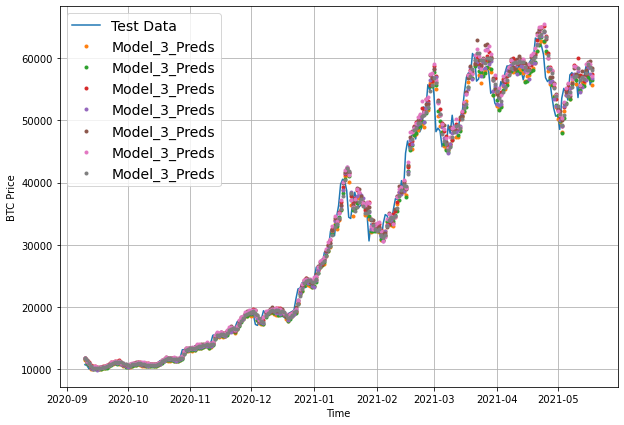

In [235]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="Model_3_Preds")

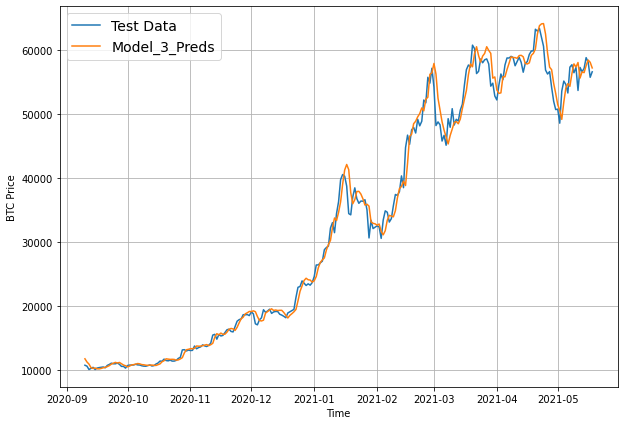

In [236]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset,
                 format="-",
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="Model_3_Preds")

## Which of our models is performing best so far?

So we've trained a few models, now let's compaare them and see how they've gone...

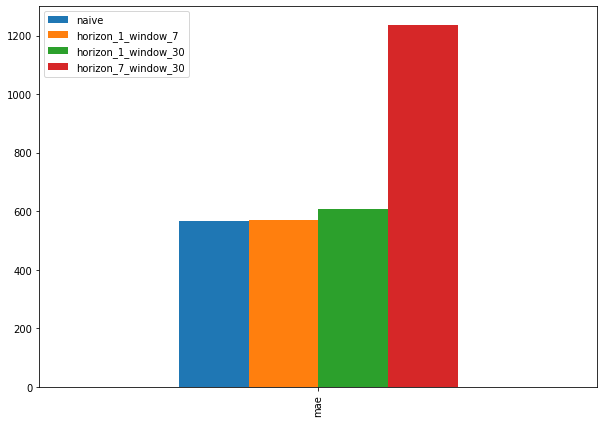

In [237]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

> 🔑 **Note:** You might be wondering, why are the naïve results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t + 1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naïve model will often get fairly good results.

📖 **Resource:** For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424).

## Model 4: Conv1D

In [238]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [239]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [240]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

We need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet...

In [241]:
# Chech data input shape
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [242]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [243]:
from tensorflow.keras.layers import Lambda
expand_dims_layer = Lambda(lambda x : tf.expand_dims(x, axis=1))    # add an extra dimension for `input_dim`

In [244]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}")  # (WINDOW_SIZE, 1)
print(f"Original values with expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [245]:
from tensorflow.keras.layers import Conv1D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

tf.random.set_seed(42)

# Create Conv1D
model_4 = Sequential([
    Lambda(lambda x : tf.expand_dims(x, axis=1)),
    Conv1D(filters=128, 
           kernel_size=7,
           strides=1,
           padding="causal",
           activation="relu"),
    Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=Adam())

# Fit the model
history_model_4 = model_4.fit(train_windows,
                              train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1486.8540INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 45ms/step - loss: 1486.8540 - val_loss: 1494.0684
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 359.4668 - val_loss: 1882.3083
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 247.5196INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 237.6437 - val_loss: 1228.2827
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 210.5235INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 208.5991 - val_loss: 1095.6581
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 207.1151INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 197.1485 - val_loss: 1087.9990
Epoch 6/100
17/18 [===========================>..] - ETA: 0s - loss: 190.5716INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 192.2835 - val_loss: 1075.7545
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 191.2741INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 191.2741 - val_loss: 1050.4601
Epoch 8/100
18/18 [==============================] - 0s 5ms/step - loss: 186.0932 - val_loss: 1054.7795
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 183.6489 - val_loss: 1061.0854
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 181.0739INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 181.0739 - val_loss: 1007.3293
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 205.7810INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 177.9125 - val_loss: 986.4634
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 177.0196 - val_loss: 1027.5630
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 173.0899 - val_loss: 998.0865
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 169.1067INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 169.1067 - val_loss: 957.6588
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 167.7209INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 168.9441 - val_loss: 951.0867
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 164.5699INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 162.9818 - val_loss: 910.6180
Epoch 17/100
18/18 [==============================] - 0s 4ms/step - loss: 159.8225 - val_loss: 950.2710
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 158.4490 - val_loss: 932.6097
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 86.1377INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 155.9717 - val_loss: 865.1636
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 152.4890INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 152.4890 - val_loss: 851.0284
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 149.1742INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 150.2419 - val_loss: 823.7582
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 146.5942INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 65ms/step - loss: 146.5942 - val_loss: 817.5502
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 164.5944INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 143.0213 - val_loss: 815.2192
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 157.9769INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 142.4472 - val_loss: 811.6649
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 138.6825INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 138.6825 - val_loss: 773.2652
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 135.1407INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 136.4112 - val_loss: 747.6426
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 135.5997INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 135.5997 - val_loss: 736.6955
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 135.0159INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 131.8269 - val_loss: 729.3217
Epoch 29/100
14/18 [======================>.......] - ETA: 0s - loss: 130.7494INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 42ms/step - loss: 130.4352 - val_loss: 715.5738
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 132.4180 - val_loss: 827.3417
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 144.1670 - val_loss: 841.3746
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 136.7511INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 41ms/step - loss: 136.0106 - val_loss: 699.7342
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 127.9241 - val_loss: 703.1788
Epoch 34/100
15/18 [========================>.....] - ETA: 0s - loss: 123.6436INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 124.6079 - val_loss: 687.4135
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 122.7475INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 122.7475 - val_loss: 679.9236
Epoch 36/100
18/18 [==============================] - 0s 4ms/step - loss: 125.2610 - val_loss: 723.9998
Epoch 37/100
16/18 [=========================>....] - ETA: 0s - loss: 122.6791INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 39ms/step - loss: 123.2823 - val_loss: 657.9591
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 121.4682INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 35ms/step - loss: 121.4682 - val_loss: 653.3033
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 121.0963 - val_loss: 677.5060
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 118.4024INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 37ms/step - loss: 118.3144 - val_loss: 649.8809
Epoch 41/100
18/18 [==============================] - ETA: 0s - loss: 118.4313INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 118.4313 - val_loss: 635.9149
Epoch 42/100
17/18 [===========================>..] - ETA: 0s - loss: 122.6255INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 38ms/step - loss: 121.4736 - val_loss: 633.3147
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 116.5272 - val_loss: 652.6731
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 73.2220INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 119.4422 - val_loss: 625.1490
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 118.1001 - val_loss: 656.5295
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 92.4394INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 63ms/step - loss: 117.7151 - val_loss: 618.1378
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 118.6838 - val_loss: 691.4000
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 116.0792 - val_loss: 641.4034
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 115.9599 - val_loss: 619.1439
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 116.6826 - val_loss: 619.1306
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 114.2372 - val_loss: 622.6335
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 121.9417INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 116.6652 - val_loss: 609.0570
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 115.7129 - val_loss: 623.0091
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6851 - val_loss: 614.8851
Epoch 55/100
18/18 [==============================] - 0s 4ms/step - loss: 114.2360 - val_loss: 610.8499
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 115.2769 - val_loss: 732.5938
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 133.7723 - val_loss: 640.8218
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 122.2336 - val_loss: 662.8845
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 82.4216INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 111.8640 - val_loss: 597.4778
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 112.1637 - val_loss: 637.3140
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 112.4486 - val_loss: 602.3149
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3270 - val_loss: 597.6086
Epoch 63/100
17/18 [===========================>..] - ETA: 0s - loss: 113.7211INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 36ms/step - loss: 113.5292 - val_loss: 596.5159
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 112.1835 - val_loss: 661.0566
Epoch 65/100
 1/18 [>.............................] - ETA: 0s - loss: 141.3043INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 43ms/step - loss: 114.9117 - val_loss: 591.5357
Epoch 66/100
17/18 [===========================>..] - ETA: 0s - loss: 112.6670INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 59ms/step - loss: 112.4425 - val_loss: 588.0613
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 109.1343 - val_loss: 635.2737
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2148 - val_loss: 730.8607
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 130.5157 - val_loss: 694.6175
Epoch 70/100
13/18 [====================>.........] - ETA: 0s - loss: 116.7278INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 62ms/step - loss: 117.3485 - val_loss: 582.7702
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 111.7962 - val_loss: 605.1553
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 101.6192INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 56ms/step - loss: 110.5302 - val_loss: 581.5660
Epoch 73/100
18/18 [==============================] - 0s 9ms/step - loss: 111.2924 - val_loss: 614.2627
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3728 - val_loss: 586.3537
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 109.9528 - val_loss: 598.8423
Epoch 76/100
18/18 [==============================] - 0s 9ms/step - loss: 111.0880 - val_loss: 584.3826
Epoch 77/100
17/18 [===========================>..] - ETA: 0s - loss: 110.6435INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 45ms/step - loss: 109.7770 - val_loss: 581.2430
Epoch 78/100
18/18 [==============================] - ETA: 0s - loss: 109.4179INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 47ms/step - loss: 109.4179 - val_loss: 578.7866
Epoch 79/100
18/18 [==============================] - 0s 10ms/step - loss: 110.2762 - val_loss: 598.5272
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8370 - val_loss: 595.3962
Epoch 81/100
18/18 [==============================] - ETA: 0s - loss: 108.4690INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 56ms/step - loss: 108.4690 - val_loss: 575.3320
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1399 - val_loss: 575.8414
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 112.0317 - val_loss: 684.0498
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 116.1538 - val_loss: 584.0785
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 109.5261 - val_loss: 575.6067
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 109.4163 - val_loss: 614.9031
Epoch 87/100
12/18 [===================>..........] - ETA: 0s - loss: 111.0854INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 55ms/step - loss: 109.8334 - val_loss: 573.0806
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 108.7679 - val_loss: 605.2974
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 110.9292 - val_loss: 581.9469
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 107.6792 - val_loss: 637.5427
Epoch 91/100
18/18 [==============================] - 0s 11ms/step - loss: 113.2019 - val_loss: 615.0515
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 110.6723 - val_loss: 581.5016
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 114.0798 - val_loss: 612.8641
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 109.8304 - val_loss: 579.2549
Epoch 95/100
 1/18 [>.............................] - ETA: 0s - loss: 136.2679INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 51ms/step - loss: 108.3462 - val_loss: 572.3138
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 114.8912 - val_loss: 635.6720
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8816 - val_loss: 606.7849
Epoch 98/100
18/18 [==============================] - 0s 8ms/step - loss: 111.1247 - val_loss: 576.2916
Epoch 99/100
13/18 [====================>.........] - ETA: 0s - loss: 105.6281INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets


18/18 [==============================] - 1s 47ms/step - loss: 109.7499 - val_loss: 570.7388
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 111.0033 - val_loss: 615.6102


In [246]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            6400      
                                                                 
 dense_1714 (Dense)          (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [247]:
# Evaluate model...
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 615.6102


615.6101684570312

In [248]:
# Load back in best performing Conv1D model
model_4 = load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.7388


570.73876953125

In [249]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8893.429, 8788.89 , 9020.29 , 8796.402, 8743.089, 8764.085,
       8680.323, 8538.849, 8475.116, 8526.651], dtype=float32)>

In [250]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.7388,
 'mape': 2.5461204,
 'mase': 1.00263,
 'mse': 1183499.9,
 'rmse': 1087.8878}

## Model 5: RNN (LSTM)

Let's build an RNN model for time series data.

We can use the same data we created for Conv1D model.

In [251]:
from tensorflow.keras.layers import LSTM, Lambda, Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = Input(shape=(WINDOW_SIZE))
x = Lambda(lambda x : tf.expand_dims(x, axis=1))(inputs)
# x = LSTM(128, return_sequences=True, activation="relu")(x)
x = LSTM(128, activation="relu")(x)
# x = Dense(32, activation="relu")(x)
output = Dense(HORIZON, activation="linear")(x)
model_5 = Model(inputs, output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=Adam())

# Fit the model
history_model_5 = model_5.fit(train_windows,
                              train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 2405.3933INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 9s 393ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 695.4739INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 5s 294ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 242.9828INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 201ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 182.5865INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 232ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
18/18 [==============================] - ETA: 0s - loss: 173.5414INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 180ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 171.3403INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 186ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
18/18 [==============================] - 0s 14ms/step - loss: 157.6712 - val_loss: 914.8642
Epoch 9/100
18/18 [==============================] - 0s 12ms/step - loss: 166.5143 - val_loss: 1079.0776
Epoch 10/100
14/18 [======================>.......] - ETA: 0s - loss: 159.1116INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 235ms/step - loss: 162.3369 - val_loss: 877.1690
Epoch 11/100
18/18 [==============================] - 0s 15ms/step - loss: 163.0841 - val_loss: 924.1126
Epoch 12/100
18/18 [==============================] - 0s 13ms/step - loss: 168.5598 - val_loss: 941.6025
Epoch 13/100
18/18 [==============================] - 0s 13ms/step - loss: 166.4726 - val_loss: 934.8436
Epoch 14/100
18/18 [==============================] - 0s 10ms/step - loss: 163.9537 - val_loss: 920.2160
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 153.0586INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 180ms/step - loss: 152.9470 - val_loss: 856.2653
Epoch 16/100
18/18 [==============================] - 0s 14ms/step - loss: 147.4420 - val_loss: 898.9914
Epoch 17/100
18/18 [==============================] - 0s 12ms/step - loss: 151.0533 - val_loss: 943.1418
Epoch 18/100
18/18 [==============================] - 0s 10ms/step - loss: 157.8232 - val_loss: 924.0046
Epoch 19/100
18/18 [==============================] - 0s 10ms/step - loss: 155.9198 - val_loss: 911.4753
Epoch 20/100
18/18 [==============================] - 0s 13ms/step - loss: 155.6456 - val_loss: 862.6680
Epoch 21/100
18/18 [==============================] - 0s 10ms/step - loss: 153.1514 - val_loss: 862.5831
Epoch 22/100
18/18 [==============================] - 0s 11ms/step - loss: 151.4883 - val_loss: 863.8172
Epoch 23/100
18/18 [==============================] - 0s 16ms/step - loss: 150.7770 - val_loss: 886.8356
Epoch 24/100
18/18 [==============================] - 0s 15ms/step 

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 231ms/step - loss: 146.8467 - val_loss: 845.2782
Epoch 26/100
16/18 [=========================>....] - ETA: 0s - loss: 146.8793INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 179ms/step - loss: 145.9843 - val_loss: 818.6807
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 144.3840INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 176ms/step - loss: 144.4289 - val_loss: 804.3279
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 141.4924INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 183ms/step - loss: 142.4610 - val_loss: 789.0859
Epoch 29/100
18/18 [==============================] - 0s 9ms/step - loss: 141.8739 - val_loss: 806.6758
Epoch 30/100
18/18 [==============================] - 0s 11ms/step - loss: 142.0521 - val_loss: 794.8836
Epoch 31/100
11/18 [=================>............] - ETA: 0s - loss: 138.5929INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 227ms/step - loss: 138.4690 - val_loss: 773.2812
Epoch 32/100
15/18 [========================>.....] - ETA: 0s - loss: 137.3814INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 181ms/step - loss: 137.1986 - val_loss: 772.2625
Epoch 33/100
18/18 [==============================] - 0s 11ms/step - loss: 135.9342 - val_loss: 786.4805
Epoch 34/100
10/18 [===============>..............] - ETA: 0s - loss: 138.4026INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 180ms/step - loss: 136.1931 - val_loss: 744.4506
Epoch 35/100
18/18 [==============================] - 0s 12ms/step - loss: 133.4513 - val_loss: 756.2970
Epoch 36/100
15/18 [========================>.....] - ETA: 0s - loss: 132.2189INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 218ms/step - loss: 134.0992 - val_loss: 735.1729
Epoch 37/100
18/18 [==============================] - 0s 18ms/step - loss: 130.6932 - val_loss: 745.9099
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 129.4177INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 183ms/step - loss: 129.2891 - val_loss: 717.2498
Epoch 39/100
18/18 [==============================] - 0s 14ms/step - loss: 129.6088 - val_loss: 719.0665
Epoch 40/100
18/18 [==============================] - 0s 10ms/step - loss: 129.6111 - val_loss: 732.0632
Epoch 41/100
18/18 [==============================] - ETA: 0s - loss: 127.1393INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 174ms/step - loss: 127.1393 - val_loss: 702.9354
Epoch 42/100
16/18 [=========================>....] - ETA: 0s - loss: 125.2375INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 228ms/step - loss: 125.6113 - val_loss: 700.8702
Epoch 43/100
18/18 [==============================] - 0s 15ms/step - loss: 125.9959 - val_loss: 704.3682
Epoch 44/100
17/18 [===========================>..] - ETA: 0s - loss: 125.8970INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 178ms/step - loss: 125.2241 - val_loss: 698.7766
Epoch 45/100
16/18 [=========================>....] - ETA: 0s - loss: 120.5754INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 182ms/step - loss: 122.5007 - val_loss: 683.0590
Epoch 46/100
16/18 [=========================>....] - ETA: 0s - loss: 125.3609INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 183ms/step - loss: 124.4726 - val_loss: 679.1873
Epoch 47/100
18/18 [==============================] - 0s 15ms/step - loss: 122.1862 - val_loss: 705.4241
Epoch 48/100
16/18 [=========================>....] - ETA: 0s - loss: 120.7986INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 184ms/step - loss: 122.0458 - val_loss: 677.0784
Epoch 49/100
16/18 [=========================>....] - ETA: 0s - loss: 120.7791INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 183ms/step - loss: 121.1548 - val_loss: 674.6848
Epoch 50/100
18/18 [==============================] - 0s 15ms/step - loss: 122.8890 - val_loss: 691.4816
Epoch 51/100
18/18 [==============================] - 0s 8ms/step - loss: 122.2994 - val_loss: 737.3929
Epoch 52/100
11/18 [=================>............] - ETA: 0s - loss: 128.5450INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 218ms/step - loss: 121.2944 - val_loss: 657.2365
Epoch 53/100
17/18 [===========================>..] - ETA: 0s - loss: 120.2341INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 152ms/step - loss: 119.7668 - val_loss: 652.7970
Epoch 54/100
18/18 [==============================] - 0s 8ms/step - loss: 120.1222 - val_loss: 654.4439
Epoch 55/100
11/18 [=================>............] - ETA: 0s - loss: 127.3472INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 119.2566 - val_loss: 647.2831
Epoch 56/100
11/18 [=================>............] - ETA: 0s - loss: 122.4764INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 120.0544 - val_loss: 643.7808
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 123.1243 - val_loss: 671.1797
Epoch 58/100
12/18 [===================>..........] - ETA: 0s - loss: 118.0024INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 118.4059 - val_loss: 640.2656
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 117.7119 - val_loss: 645.3837
Epoch 60/100
12/18 [===================>..........] - ETA: 0s - loss: 117.1983INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 134ms/step - loss: 118.5346 - val_loss: 638.7429
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 118.3129 - val_loss: 689.4144
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4350 - val_loss: 748.5565
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 123.1006 - val_loss: 651.8298
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 115.9679 - val_loss: 672.9166
Epoch 65/100
11/18 [=================>............] - ETA: 0s - loss: 120.7008INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 118.8341 - val_loss: 631.7538
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 116.2212 - val_loss: 634.5445
Epoch 67/100
12/18 [===================>..........] - ETA: 0s - loss: 113.0850INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 116.1580 - val_loss: 623.8932
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 115.5543 - val_loss: 635.4929
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 120.5866 - val_loss: 626.3387
Epoch 70/100
12/18 [===================>..........] - ETA: 0s - loss: 111.8156INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 114.9188 - val_loss: 619.3181
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8998 - val_loss: 650.9373
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 118.2033 - val_loss: 630.5287
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 115.3612 - val_loss: 623.0369
Epoch 74/100
18/18 [==============================] - 0s 8ms/step - loss: 115.0345 - val_loss: 623.0776
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2057 - val_loss: 640.5281
Epoch 76/100
10/18 [===============>..............] - ETA: 0s - loss: 116.2252INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 142ms/step - loss: 114.1402 - val_loss: 614.4062
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5973 - val_loss: 689.8776
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 117.2611 - val_loss: 645.2790
Epoch 79/100
10/18 [===============>..............] - ETA: 0s - loss: 112.2463INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 114.1995 - val_loss: 608.7159
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7125 - val_loss: 614.9222
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 113.3684 - val_loss: 634.8466
Epoch 82/100
11/18 [=================>............] - ETA: 0s - loss: 122.9989INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 115.9701 - val_loss: 607.8510
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3599 - val_loss: 628.8181
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 114.4113 - val_loss: 628.5579
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8363 - val_loss: 634.7715
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 115.5462 - val_loss: 613.5223
Epoch 87/100
11/18 [=================>............] - ETA: 0s - loss: 116.9523INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 139ms/step - loss: 112.5059 - val_loss: 604.7603
Epoch 88/100
11/18 [=================>............] - ETA: 0s - loss: 114.8154INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 151ms/step - loss: 111.7706 - val_loss: 601.5748
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 111.8470 - val_loss: 624.0131
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6354 - val_loss: 662.9452
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 116.1836 - val_loss: 636.0310
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 113.1700 - val_loss: 606.0366
Epoch 93/100
10/18 [===============>..............] - ETA: 0s - loss: 111.9717INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 112.4748 - val_loss: 599.8319
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 111.2637 - val_loss: 601.3256
Epoch 95/100
12/18 [===================>..........] - ETA: 0s - loss: 109.0149INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 99ms/step - loss: 111.0185 - val_loss: 597.1485
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 112.3787 - val_loss: 601.1596
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4700 - val_loss: 626.1573
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 111.7326 - val_loss: 601.0142
Epoch 99/100
12/18 [===================>..........] - ETA: 0s - loss: 109.4926INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 110.7480 - val_loss: 594.6030
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9943 - val_loss: 595.9847


In [252]:
# Load in best version of model 5 and evaluate on the test data
model_5 = load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 594.6030


594.6029663085938

In [253]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8978.46 , 8810.951, 8997.779, 8836.308, 8731.047], dtype=float32)>

In [254]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 594.60297,
 'mape': 2.6717565,
 'mase': 1.0445527,
 'mse': 1267231.9,
 'rmse': 1125.7139}

In [255]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used almost for any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Elon Musk tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about Bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [256]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [257]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [258]:
# Create date ranges of where specific block reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [259]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [260]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


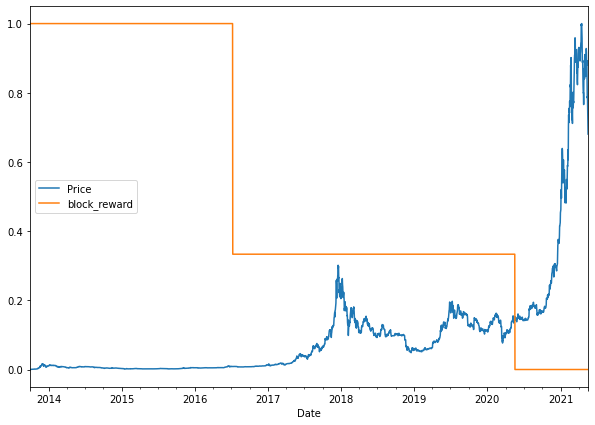

In [261]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making windowed dataset with pandas

Previously, we turned our unnivariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to window our multivariate data.

In [262]:
# Setup dataset hyperparamaters
HORIZON = 1
WINDOWS_SIZE = 7

In [263]:
# Make a copy of the historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):    # shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [264]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


What we've done is created a way to window our dataset directly from a pandas dataframe.
```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [265]:
# Create X (windows) and y (horizon) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [266]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [267]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [268]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = Sequential([
    Dense(128, activation="relu"),
    Dense(HORIZON, activation="linear") # linear acitvation is same as having no activation
], name="model_6_dense_multivariate")    # name our model so we can save it

# 2. Compile the model
model_6.compile(loss="mae",
                optimizer=Adam())

# 3. Fit the model
history_model_6 = model_6.fit(x=X_train,
                              y=y_train,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(X_test, y_test),
                              callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 2853.4023INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 31ms/step - loss: 1234.6804 - val_loss: 2061.9077
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 337.7052INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 351.5053 - val_loss: 1908.6733
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 249.1732INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 235.4153 - val_loss: 1329.0585
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 271.0341INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 27ms/step - loss: 208.6112 - val_loss: 1102.1342
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 196.5770 - val_loss: 1107.8474
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 145.3367INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 187.2245 - val_loss: 1036.1720
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 231.5105INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 182.0245 - val_loss: 1019.2928
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 151.5176INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 175.7059 - val_loss: 977.8488
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 142.1689INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 170.1784 - val_loss: 954.4037
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 177.8448INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 164.4430 - val_loss: 913.5148
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 171.3627INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 158.6892 - val_loss: 874.2507
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 147.0429INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 152.0732 - val_loss: 861.0418
Epoch 13/100
18/18 [==============================] - 0s 4ms/step - loss: 151.1057 - val_loss: 886.1207
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 152.2400INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 147.5482 - val_loss: 837.8616
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 146.6370INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 142.3497 - val_loss: 794.4788
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 125.8471INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 137.5206 - val_loss: 778.4052
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 125.1490INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 135.8190 - val_loss: 772.4532
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 145.6097INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 134.8562 - val_loss: 747.4802
Epoch 19/100
18/18 [==============================] - 0s 4ms/step - loss: 130.3347 - val_loss: 761.0554
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 145.2515INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 128.6775 - val_loss: 701.8977
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 158.9073INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 129.5576 - val_loss: 691.0128
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 176.6308INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 125.8060 - val_loss: 684.4119
Epoch 23/100
18/18 [==============================] - 0s 4ms/step - loss: 125.5263 - val_loss: 692.1298
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 134.1221INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 122.4765 - val_loss: 674.2216
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 133.5674INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 121.1171 - val_loss: 669.6441
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 127.2623 - val_loss: 690.0403
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 180.3230INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 28ms/step - loss: 124.6204 - val_loss: 643.9724
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 118.2544 - val_loss: 656.2767
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 109.8149INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 119.6374 - val_loss: 633.4547
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 130.2605INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 27ms/step - loss: 119.5001 - val_loss: 625.3953
Epoch 31/100
18/18 [==============================] - 0s 4ms/step - loss: 114.5633 - val_loss: 668.5064
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 121.3793INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 24ms/step - loss: 116.9750 - val_loss: 617.1061
Epoch 33/100
18/18 [==============================] - 0s 4ms/step - loss: 115.2438 - val_loss: 649.0989
Epoch 34/100
18/18 [==============================] - 0s 4ms/step - loss: 114.5187 - val_loss: 632.1375
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 112.6759INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 113.6357 - val_loss: 607.4173
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 115.2605 - val_loss: 626.4319
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 141.7286INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 113.7020 - val_loss: 606.2318
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 107.1735INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 111.4061 - val_loss: 603.2919
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 127.4214INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 112.7722 - val_loss: 596.0060
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 100.2578INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 52ms/step - loss: 110.5418 - val_loss: 593.2170
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8671 - val_loss: 609.1062
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 115.7249 - val_loss: 607.4877
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3313 - val_loss: 606.2029
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 65.3244INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 109.7027 - val_loss: 586.1215
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8748 - val_loss: 593.8445
Epoch 46/100
18/18 [==============================] - 0s 4ms/step - loss: 109.8641 - val_loss: 586.4581
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 112.3587 - val_loss: 655.4489
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 109.1614 - val_loss: 598.7234
Epoch 49/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3029 - val_loss: 589.2489
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 111.1971 - val_loss: 649.3788
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 110.8514 - val_loss: 602.7667
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 111.8331 - val_loss: 599.2957
Epoch 53/100
18/18 [==============================] - 0s 4ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 110.4068 - val_loss: 575.7752
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 108.6609 - val_loss: 785.9749
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 124.9823 - val_loss: 670.3782
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 112.8591 - val_loss: 580.2877
Epoch 59/100
18/18 [==============================] - 0s 4ms/step - loss: 107.2513 - val_loss: 597.5082
Epoch 60/100
18/18 [==============================] - 0s 4ms/step - loss: 109.2322 - val_loss: 632.2958
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 109.3519 - val_loss: 591.5412
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 108.4084 - val_loss: 617.5801
Epoch 63/100
18/18 [==============================] - 0s 3ms/step - loss: 113.5326 - val_loss: 613.1476
Epoch 64/100
18/18 [==============================] - 0s 4ms/step - loss: 11

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 25ms/step - loss: 112.0475 - val_loss: 575.5540
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2830 - val_loss: 590.7802
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 106.7918 - val_loss: 586.8840
Epoch 68/100
18/18 [==============================] - 0s 4ms/step - loss: 112.2987 - val_loss: 696.5287
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 124.7808 - val_loss: 698.5261
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 119.3443 - val_loss: 581.2100
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 109.9960 - val_loss: 607.6742
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 106.7779INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 27ms/step - loss: 106.7711 - val_loss: 573.6142
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 110.2485 - val_loss: 618.8947
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 105.5330 - val_loss: 574.9452
Epoch 75/100
18/18 [==============================] - 0s 4ms/step - loss: 107.3177 - val_loss: 606.1979
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8084 - val_loss: 582.2403
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 83.6437INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 107.2528 - val_loss: 571.8563
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 106.2309 - val_loss: 572.2830
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 105.8568 - val_loss: 596.5461
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 107.8418 - val_loss: 577.2400
Epoch 81/100
 1/18 [>.............................] - ETA: 0s - loss: 95.0620INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 105.1101 - val_loss: 568.4897
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 114.1867 - val_loss: 592.5609
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 107.9631 - val_loss: 651.6213
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 109.6690 - val_loss: 568.9340
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 105.8219 - val_loss: 571.5334
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 104.8628 - val_loss: 579.3859
Epoch 87/100
18/18 [==============================] - 0s 4ms/step - loss: 104.7148 - val_loss: 582.9178
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 106.8899 - val_loss: 569.0820
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 105.4376 - val_loss: 569.3439
Epoch 90/100
18/18 [==============================] - 0s 4ms/step - loss: 10

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 0s 26ms/step - loss: 107.7017 - val_loss: 567.8899
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9951 - val_loss: 626.7441


In [269]:
# Evaluate multivariate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 626.7440


626.7440185546875

In [270]:
# Load in and evaluate best performing model
model_6 = load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8899


567.889892578125

In [271]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8844.684, 8769.905, 9045.17 , 8747.686, 8728.429, 8772.757,
       8667.292, 8503.437, 8470.313, 8527.244], dtype=float32)>

In [272]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.8899,
 'mape': 2.5460758,
 'mase': 0.99762523,
 'mse': 1164816.4,
 'rmse': 1079.2666}

In [273]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171743.8,
 'rmse': 1082.4711}

In [274]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

> 🛠 **Exercise(s):**
1. Try adding an extra `tf.keras.layers.Dense()` layer with 128 hidden units to `model_6`, how does this effect model performance?
2. Is there a better way to create this model? As in, should the `block_reward` feature be bundled in with the Bitcoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for `block_reward`) works better?

## Model 7: N-BEATS Algorithm

Let's now build the biggest, baddest (though may not be the baddest, as in, it perform really well...) times series forecasting model we've built so far.

More specifically, we're going to be replicating the alogorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our problem

### Building an testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow, we can use subclassing:
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [275]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs):     # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name, etc.)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of n_layers fully connected layers each has ReLU activation
        self.hidden = [Dense(n_neurons, activation="relu") for _ in range(n_layers)]

        # Output of block is a theta layer with a linear activation
        self.theta_layer = Dense(theta_size, activation="linear")

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        # Output the backcast and the forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

Let's test our NBeatsBlock class.

To do so, we'll make some dummy inputs and outputs.

In [276]:
# Setup dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE + HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)    

In [277]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [278]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.07960171  0.32512033 -0.8428683  -0.6938985  -0.31720552 -0.5698734
 -0.6396662 ]
Forecast: 1.0071648359298706


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible, we're going to be adhering to the performant data pipeline steps in [`tf.data`](https://www.tensorflow.org/guide/data_performance) guide:



In [279]:
HORIZON = 1
WINDOW_SIZE = 7

In [280]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [281]:
# Add windowed columns 
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i + 1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [282]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [283]:
# Time to make our dataset performany using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

In [284]:
# Combine labels and features by zipping together -> (features, label)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

In [285]:
# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [286]:
train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18 of the paper: https://arxiv.org/pdf/1905.10437.pdf

In [287]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4 
N_STACKS = 30 

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

And here: https://paperswithcode.com/method/resnet

In [288]:
from tensorflow.keras.layers import add, subtract

# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = subtract([tensor_1, tensor_2])

# Add
added = add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
    * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
    * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [291]:
%%time

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, add, subtract
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, 
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stack
stack_input = Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

    # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals) # pass in the residuals

    # 6. Create the double residual stacking
    residuals = subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(loss="mae",
                optimizer=Adam())

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[EarlyStopping(monitor="val_loss",
                                     patience=200,
                                     restore_best_weights=True),
                       ReduceLROnPlateau(monitor="val_loss",
                                         patience=100,
                                         verbose=1)])


Epoch 585: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1145: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1245: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 46s, sys: 6.75 s, total: 3min 53s
Wall time: 4min 43s


In [292]:
# Evaluate N-BEATS model on test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 51ms/step - loss: 567.9252


567.9252319335938

In [293]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8834.753 , 8772.889 , 9026.839 , 8756.992 , 8760.32  , 8747.2295,
       8653.613 , 8496.917 , 8476.944 , 8510.126 ], dtype=float32)>

In [294]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 17143.014,
 'mape': 113.29306,
 'mase': 30.115526,
 'mse': 614830100.0,
 'rmse': 23722.611}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

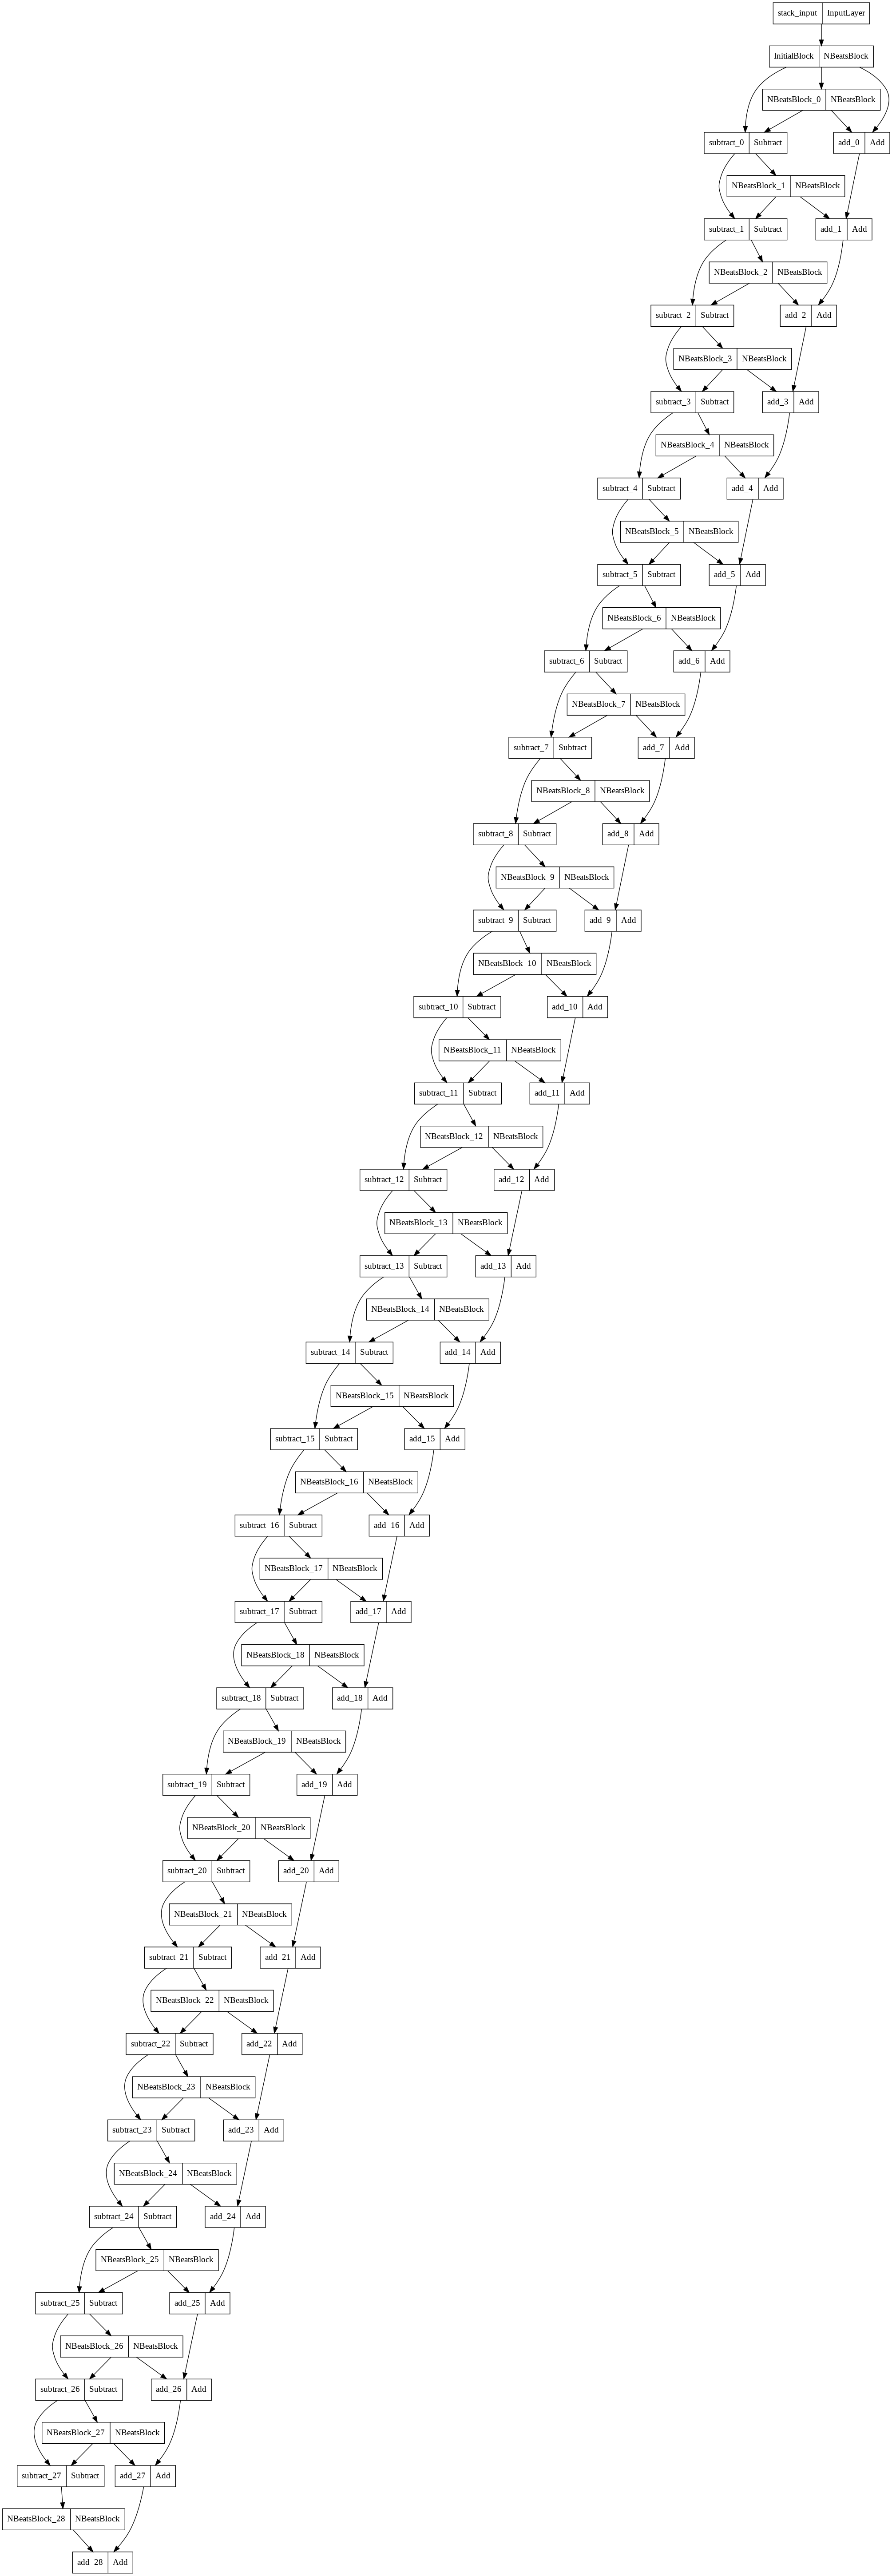

In [296]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

In [297]:
HORIZON, WINDOW_SIZE

(1, 7)

### Constructing and fitting an ensemble of models (using different loss functions)

In [298]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
    """
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

    For example, if num_iter=10, a list of 30 trained models will be returned:
    10 * len(["mae", "mse", "mape"])
    """
    # Make empty list for trained ensemble models
    ensemble_models = []

    # Create num_iter number of models per loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss function
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

            # Construct a simple model (similar to model_1)
            model = Sequential([
                # Initialize dense layers with normal distribution for estimating prediction intervals later on
                Dense(128, kernel_initializer="he_normal", activation="relu"),
                Dense(128, kernel_initializer="he_normal", activation="relu"),
                Dense(HORIZON)
            ])

            #  Compile simple model with current loss function
            model.compile(loss=loss_function,
                          optimizer=Adam(),
                          metrics=["mae", "mse"])
      
            # Fit the current model
            model.fit(train_data,
                      epochs=num_epochs,
                      verbose=0,
                      validation_data=test_data,
                      callbacks=[EarlyStopping(monitor="val_loss",
                                               patience=200,
                                               restore_best_weights=True),
                                 ReduceLROnPlateau(monitor="val_loss",
                                                   patience=100,
                                                   verbose=1)])
            # Append fitted model to list of ensemble models
            ensemble_models.append(model)

    return ensemble_models

In [299]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 746: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 965: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 510: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 610: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 409: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 509: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

In [301]:
len(ensemble_models)

15

In [300]:
ensemble_models

### Make predictions with our ensemble model

In [302]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [303]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

CPU times: user 918 ms, sys: 31.1 ms, total: 949 ms
Wall time: 1.01 s


In [304]:
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8806.444,  8777.493,  9021.862, ..., 50123.184, 49101.54 ,
        46783.824],
       [ 8803.593,  8759.023,  8979.093, ..., 48924.047, 48634.8  ,
        45424.22 ],
       [ 8745.424,  8733.034,  9101.386, ..., 49267.164, 47660.426,
        45370.047],
       ...,
       [ 8837.495,  8752.15 ,  9057.246, ..., 49206.824, 49678.402,
        46304.434],
       [ 8726.444,  8808.476,  9096.605, ..., 49560.92 , 48496.223,
        45103.875],
       [ 8815.368,  8759.666,  9039.025, ..., 49711.68 , 48046.5  ,
        45818.91 ]], dtype=float32)>

Our ensemble preds come out in multiple dimensions but to combine into **point predictions** we can leverage the mean of all of the predictions or the median - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [305]:
# Evaluate ensemble model predictions 
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_preds)
ensemble_results

{'mae': 579.4182,
 'mape': 2.656067,
 'mase': 1.0178773,
 'mse': 1178906.0,
 'rmse': 1085.5637}

In [309]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8790.174, 8779.622, 9057.702, 8720.233, 8749.518, 8711.267,
       8658.54 , 8478.787, 8453.681, 8522.23 ], dtype=float32)>

In [311]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8803.593, 8777.493, 9057.246, 8708.303, 8744.435, 8714.33 ,
       8652.636, 8478.887, 8451.976, 8525.819], dtype=float32)

In [312]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 567.14087,
 'mape': 2.580557,
 'mase': 0.9963094,
 'mse': 1142734.0,
 'rmse': 1068.9874}

In [313]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results

{'mae': 565.75586,
 'mape': 2.576158,
 'mase': 0.99387634,
 'mse': 1135319.8,
 'rmse': 1065.5138}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

1. Take the predictions from a number of randomly initialzed models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

* https://en.wikipedia.org/wiki/1.96
* https://eng.uber.com/neural-networks-uncertainty-estimation/

In [316]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly intialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds 
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

In [317]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

> 📖 **Resource:** Many of the steps we've taken above have inspired/referenced from the Machine Learning Mastery blog post on [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)

In [318]:
X_test.index[:10]

DatetimeIndex(['2019-11-10', '2019-11-11', '2019-11-12', '2019-11-13',
               '2019-11-14', '2019-11-15', '2019-11-16', '2019-11-17',
               '2019-11-18', '2019-11-19'],
              dtype='datetime64[ns]', name='Date', freq=None)

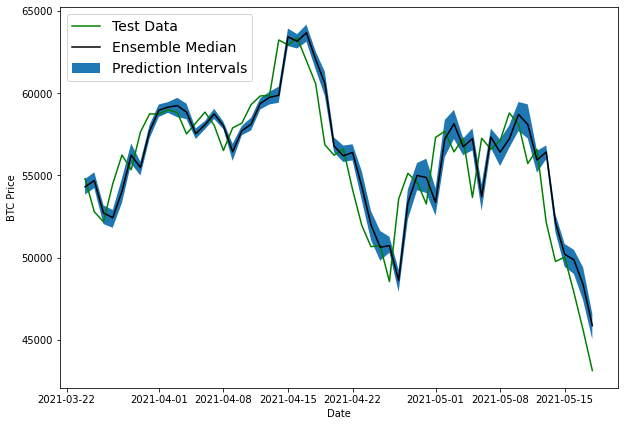

In [319]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm...

So far all of our models predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> 🔑 **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.